In [ ]:
%pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
device = "cuda"

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-7B-Instruct",
    device_map=device,
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    output_hidden_states=True
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-7B-Instruct")


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import torch

In [ ]:
import pandas

In [ ]:
prompt = "go jurong point crazy available bugis n great"
messages = [
    {"role": "system", "content": "You are a text classification model. Your only task is to classify input text as SMS spam or not. Respond ONLY with '1' for SMS spam and '0' for not spam. WITHOUT USING ANY SENTENCES JUST 1 OR 0"},
    {"role": "user", "content": prompt}
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

model_inputs = tokenizer([text], return_tensors="pt").to(device)
prompt_inputs = tokenizer([prompt], return_tensors="pt", add_special_tokens=False).to(device)

generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=512,
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]


In [ ]:
def gen_response_with_probs(prompt, top_k=5):


    messages = [
          {"role": "system", "content": "You are a text classification model. Your only task is to classify input text as SMS spam or not. Respond ONLY with '1' for SMS spam and '0' for not spam."},
          {"role": "user", "content": prompt}
        ]

    text = tokenizer.apply_chat_template(
          messages,
          tokenize=False,
          add_generation_prompt=True,
        )

    inputs = tokenizer([text], return_tensors="pt").to(device)
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=1,
        return_dict_in_generate=True,
        output_scores=True,
        temperature = 3.5
    )


    logits = outputs.scores[0]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    top_k_probs, top_k_token_ids = torch.topk(probs, k=top_k, dim=-1)
    top_k_tokens = [tokenizer.decode([token_id], skip_special_tokens=True) for token_id in top_k_token_ids[0]]
    return top_k_tokens, top_k_token_ids[0].tolist(), top_k_probs[0].tolist()


prompt = " elon is my favorite one"
top_tokens, top_token_ids, top_probs = gen_response_with_probs(prompt, top_k=5)
print(f"Top Tokens: {top_tokens}")
print(f"Top Token IDs: {top_token_ids}")
print(f"Top Probabilities: {top_probs}")

Top Tokens: ['0', '#', '!', '$', '"']
Top Token IDs: [15, 2, 0, 3, 1]
Top Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:

prompt_inputs = tokenizer([prompt], return_tensors="pt", add_special_tokens=False).to(device)
model_inputs = tokenizer([text], return_tensors="pt").to(device)



first_lenght = 5 + len(prompt_inputs.input_ids[0])
second = len(model_inputs.input_ids[0]) - first_lenght

print(prompt_inputs.input_ids)

print(model_inputs.input_ids[0][second: second + len(prompt_inputs.input_ids[0])])
response2 = tokenizer.batch_decode(prompt_inputs.input_ids, skip_special_tokens=False)[0]
print(response2)

outputs = model(**model_inputs, output_hidden_states=True)
hidden_states = outputs.hidden_states
print(hidden_states[6].size())
ho = hidden_states[1][0][second: second + len(prompt_inputs.input_ids[0])]

print(ho.size())

tensor([[ 3346, 16037,   644,  1459, 14264,  2500,  9876,   285,   308,  2244]],
       device='cuda:0')
tensor([ 3346, 16037,   644,  1459, 14264,  2500,  9876,   285,   308,  2244],
       device='cuda:0')
go jurong point crazy available bugis n great
torch.Size([1, 72, 3584])
torch.Size([10, 3584])


In [ ]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file = pd.read_csv("/content/drive/My Drive/Colab Notebooks/spam.csv", delimiter=',', encoding='latin1')
print(file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         

In [ ]:
file2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/enron_spam_data.csv", delimiter=',', encoding='latin1')
file2

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


In [ ]:
from collections import Counter
import re
import string
from nltk.corpus import stopwords

In [ ]:
from gensim.utils import tokenize


file.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)
file.result = file.result.map({'ham':0, 'spam':1})
file.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)



file2.rename(columns={'Spam/Ham': 'result', 'Message': 'emails'}, inplace=True)
file2.result = file2.result.map({'ham':0, 'spam':1})
file2.drop(columns=["Message ID", "Subject", "Date"], inplace=True)

In [ ]:
file2 = file2.dropna()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def transform_file(file_for_tranfrom):
  file_for_tranfrom['transform_text'] = file_for_tranfrom['emails'].str.lower()

  file_for_tranfrom['transform_text'] = file_for_tranfrom['transform_text'].apply(lambda x: list(tokenize(x)))

  file_for_tranfrom['transform_text'] = file_for_tranfrom['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])


  stop_words = set(stopwords.words('english'))
  file_for_tranfrom['transform_text'] = file_for_tranfrom['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

  file_for_tranfrom['transform_text'] = file_for_tranfrom['transform_text'].apply(lambda x: ' '.join(x))

  return file_for_tranfrom

In [ ]:
file2 = transform_file(file2)

<ipython-input-136-da9e98233b57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_for_tranfrom['transform_text'] = file_for_tranfrom['emails'].str.lower()
<ipython-input-136-da9e98233b57>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_for_tranfrom['transform_text'] = file_for_tranfrom['transform_text'].apply(lambda x: list(tokenize(x)))
<ipython-input-136-da9e98233b57>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
file = transform_file(file)

In [ ]:
condition = (file2['result'] == 1) & file2['transform_text'].apply(lambda x: isinstance(x, str))
file22 = file2.loc[condition].head(2000).reset_index(drop=True)



In [ ]:
file22

,emails,result,transform_text
0,introducing\ndoctor - formulated\nhgh\nhuman g...,1,introducing doctor formulated hgh human growth...
1,"low cost prescription medications\nsoma , ultr...",1,low cost prescription medications soma ultram ...
2,people nowthe weather or climate in any partic...,1,people nowthe weather climate particular envir...
3,"dear partner ,\nwe are a team of government of...",1,dear partner team government officials belong ...
4,stock\nprofile\nabout\ncompany\ninvestment\nhi...,1,stock profile company investment highlights pr...
...,...,...,...
1995,take the pill and enjoy great sex\ncommit a cr...,1,take pill enjoy great sex commit crime earth m...
1996,submitting your website in search engines may ...,1,submitting website search engines may increase...
1997,claim your home depot gift card - a $ 1000 val...,1,claim home depot gift card value sure find use...
1998,6831862\nsave up to 30 % off your uk car insur...,1,save uk car insurance great value car insuranc...


In [ ]:
file_clear = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cleaned_file.csv", delimiter=',', encoding='latin1')

In [ ]:
file = pd.concat([file_clear, file22], ignore_index=True)

In [ ]:
file.drop(columns=["Unnamed: 0"], inplace=True)
file

,result,emails,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
6972,1,take the pill and enjoy great sex\ncommit a cr...,take pill enjoy great sex commit crime earth m...
6973,1,submitting your website in search engines may ...,submitting website search engines may increase...
6974,1,claim your home depot gift card - a $ 1000 val...,claim home depot gift card value sure find use...
6975,1,6831862\nsave up to 30 % off your uk car insur...,save uk car insurance great value car insuranc...


In [ ]:
file["result"].value_counts()

,count
result,
0,4398
1,2579


In [ ]:
file[230:250]

,result,emails,transform_text
230,0,Where are you?when wil you reach here?,wil reach
231,0,"New Theory: Argument wins d SITUATION, but los...",new theory argument wins situation loses perso...
232,1,U 447801259231 have a secret admirer who is lo...,u secret admirer looking make contact u find r...
233,0,Tomarrow final hearing on my laptop case so i ...,tomarrow final hearing laptop case cant
234,0,PLEASSSSSSSEEEEEE TEL ME V AVENT DONE SPORTSx,pleassssssseeeeee tel v avent done sportsx
235,0,"Okay. No no, just shining on. That was meant t...",okay shining meant signing sounds better
236,0,Although i told u dat i'm into baig face watch...,although told u dat baig face watches really l...
237,0,U don't remember that old commercial?,u remember old commercial
238,0,Too late. I said i have the website. I didn't ...,late said website dont slippers
239,0,I asked you to call him now ok,asked call ok


In [ ]:
file = file.dropna()

In [ ]:
file

,result,emails,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
6972,1,take the pill and enjoy great sex\ncommit a cr...,take pill enjoy great sex commit crime earth m...
6973,1,submitting your website in search engines may ...,submitting website search engines may increase...
6974,1,claim your home depot gift card - a $ 1000 val...,claim home depot gift card value sure find use...
6975,1,6831862\nsave up to 30 % off your uk car insur...,save uk car insurance great value car insuranc...


In [ ]:
file.to_csv('final_file.csv')

In [ ]:
file

,result,emails,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
6972,1,take the pill and enjoy great sex\ncommit a cr...,take pill enjoy great sex commit crime earth m...
6973,1,submitting your website in search engines may ...,submitting website search engines may increase...
6974,1,claim your home depot gift card - a $ 1000 val...,claim home depot gift card value sure find use...
6975,1,6831862\nsave up to 30 % off your uk car insur...,save uk car insurance great value car insuranc...


In [ ]:

import pandas as pd
from google.colab import drive
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
file = pd.read_csv("/content/drive/My Drive/Colab Notebooks/final_file.csv", delimiter=',', encoding='latin1', index_col=0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = file.dropna()

In [ ]:
file["transform_text"].value_counts()

,count
transform_text,
hi sent email days ago want confirm everything please read info let know questions accepting mortgage application poor cred ok could get loa n month payment appr oval process take minute please visit link fill short form http ratelower com partid rbues sincerely manager emil gage first capital lenders lenders courtesy options ratelower com st html,1
go jurong point crazy available bugis n great world la e buffet cine got amore wat,1
ok lar joking wif u oni,1
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply,1
u dun say early hor u c already say,1
...,...
eh u remember spell name yes v naughty make v wet,1
oh k watching,1
xxxmobilemovieclub use credit click wap link next txt message click http wap xxxmobilemovieclub com n qjkgighjjgcbl,1


In [ ]:
from collections import Counter

spam_emails = file['transform_text']

spam_words = ' '.join(spam_emails).split()

word_counts = Counter(spam_words)

In [ ]:

common_words = [words for  words, counts in word_counts.items() if counts >= 3]
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + common_words
set_of_words = {word: i for i, word in enumerate(tokens)}

set_of_words

{'UNK': 0,
 'PAD': 1,
 'go': 2,
 'point': 3,
 'crazy': 4,
 'available': 5,
 'bugis': 6,
 'n': 7,
 'great': 8,
 'world': 9,
 'la': 10,
 'e': 11,
 'buffet': 12,
 'cine': 13,
 'got': 14,
 'wat': 15,
 'ok': 16,
 'lar': 17,
 'joking': 18,
 'wif': 19,
 'u': 20,
 'oni': 21,
 'free': 22,
 'entry': 23,
 'wkly': 24,
 'comp': 25,
 'win': 26,
 'fa': 27,
 'cup': 28,
 'final': 29,
 'st': 30,
 'may': 31,
 'text': 32,
 'receive': 33,
 'question': 34,
 'std': 35,
 'txt': 36,
 'rate': 37,
 'c': 38,
 'apply': 39,
 'dun': 40,
 'say': 41,
 'early': 42,
 'hor': 43,
 'already': 44,
 'nah': 45,
 'think': 46,
 'goes': 47,
 'usf': 48,
 'lives': 49,
 'around': 50,
 'though': 51,
 'freemsg': 52,
 'hey': 53,
 'darling': 54,
 'week': 55,
 'word': 56,
 'back': 57,
 'like': 58,
 'fun': 59,
 'still': 60,
 'tb': 61,
 'xxx': 62,
 'send': 63,
 'rcv': 64,
 'even': 65,
 'brother': 66,
 'speak': 67,
 'treat': 68,
 'aids': 69,
 'patent': 70,
 'per': 71,
 'request': 72,
 'set': 73,
 'callertune': 74,
 'callers': 75,
 'press':

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {torch.cuda.is_available()}")
torch.cuda.is_available()

Using device: True


True

In [ ]:
UNK_IX, PAD_IX = map(set_of_words.get, [UNK, PAD])

def as_matrix(sequences, max_len=10):
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [set_of_words.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
from tqdm import tqdm
import numpy as np
embeddings_vectors = {}
f = open('/content/drive/My Drive/Colab Notebooks/glove.6B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embeddings_vectors[word] = coef



embedding_matrix = np.zeros((len(tokens), 300))
for word, i in set_of_words.items():
    embedding_vector = embeddings_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix[1]= np.random.rand(300)

400000it [01:04, 6166.99it/s]


In [ ]:
embedding_matrix = torch.tensor(embedding_matrix, dtype = torch.float32)

In [ ]:
embedding_layer = torch.nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

In [ ]:
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedding_layer(input)

tensor([[[ 0.2123,  0.1727,  0.2463,  ...,  0.3196,  0.7648,  0.4545],
         [ 0.0074,  0.0625, -0.0974,  ..., -0.3243,  0.1961,  0.2936],
         [ 0.2644, -0.2889, -0.0008,  ...,  0.2332,  0.1842,  0.6264],
         [-0.4890,  0.1116,  0.1103,  ..., -0.3345,  0.0780, -0.2412]],

        [[ 0.2644, -0.2889, -0.0008,  ...,  0.2332,  0.1842,  0.6264],
         [ 0.1779,  0.2953,  0.1488,  ..., -0.7115, -0.2236,  0.1113],
         [ 0.0074,  0.0625, -0.0974,  ..., -0.3243,  0.1961,  0.2936],
         [-0.2583,  0.4364, -0.1138,  ...,  0.0817, -0.0044, -0.1410]]])

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
def make_batch(data, max_len = 10 , device = device):
    batch = {}
    batch["text"] = torch.tensor(as_matrix(data["transform_text"].values, max_len),device=device, dtype = torch.long)
    batch["result"] = torch.tensor(data["result"].values, device=device, dtype= torch.long)

    return batch

In [ ]:
a = make_batch(file[:9])
a

{'text': tensor([[ 2,  0,  3,  4,  5,  6,  7,  8,  9, 10],
         [16, 17, 18, 19, 20, 21,  1,  1,  1,  1],
         [22, 23, 24, 25, 26, 27, 28, 29,  0, 30],
         [20, 40, 41, 42, 43, 20, 38, 44, 41,  1],
         [45, 46, 47, 48, 49, 50, 51,  1,  1,  1],
         [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
         [65, 66, 58, 67, 68, 58, 69, 70,  1,  1],
         [71, 72,  0,  0,  0,  0,  0,  0, 73, 74],
         [79, 80, 81, 82, 83,  0, 84, 85, 86, 87]], device='cuda:0'),
 'result': tensor([0, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')}

In [ ]:
from torch import nn
from torch.nn import functional as F



class TextClassifierWithLSTM(nn.Module):
    def __init__(self, embedding_matrix, embedding_size, hid_dim, num_layers):
        super(TextClassifierWithLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_size, hid_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hid_dim, 2)


    def forward(self, x):
        embedded = self.embedding(x)
        out, (_) = self.lstm(embedded)
        lin_out = self.linear(out[:,-1,:])
        return lin_out



class Conv1DClassifier(nn.Module):
    def __init__(self, embedding_matrix, embedding_size):
        super(Conv1DClassifier, self).__init__()

        self.embedding_size = embedding_size
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.conv1 = nn.Conv1d(embedding_size, 32, kernel_size=7, padding= "same")
        self.linear = nn.Linear(32, 2)

    def forward(self, X_batch):

        x = self.embedding(X_batch)
        x = x.reshape(len(x), self.embedding_size, X_batch.size(1))
        if x.size(2) < 7:
            padding_size = 7 - x.size(2)
            x = F.pad(x, (0, padding_size), "constant", 0)

        x = F.relu(self.conv1(x))
        x, _ = x.max(dim=-1)
        x = self.linear(x)

        return x


class conv_super(nn.Module):

    def __init__(self, embedding_dim, embed_matrix):

        super(conv_super, self).__init__()
        self.filter_sizes = [5, 6, 7]
        self.module_list = nn.ModuleList([nn.Conv1d(embedding_dim, 5, kernel_size = filter, padding = "same") for filter in self.filter_sizes])
        self.first_linear = nn.Linear(15, 4)
        self.second_linear = nn.Linear(4, 2)
        self.embedding_matrix = nn.Embedding.from_pretrained(embed_matrix, freeze= False)

    def forward(self, input_ix):
        embeddings = self.embedding_matrix(input_ix)
        embeddings = torch.permute(embeddings, (0,2,1))
        outputs = []

        for conv, filter in zip(self.module_list, self.filter_sizes):

            if embeddings.size(-1) < filter:
                new_input = embeddings
                new_input = F.pad(new_input, (0, filter - embeddings.size(-1)), "constant", 0)
                outputs.append(torch.max(F.relu(conv(new_input)), dim = -1)[0])

            else:
                outputs.append(torch.max(F.relu(conv(embeddings)), dim = -1)[0])

        outputs = torch.cat(outputs, dim = -1)
        linear_output = self.second_linear(self.first_linear(outputs))
        return linear_output



In [ ]:
model = TextClassifierWithLSTM(embedding_matrix, 300, 30, 1).to(device)
weights = torch.tensor([1.0, 3.0], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):

    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            data_slice = data.iloc[indices[start : start + batch_size]]
            yield batch, data_slice

        if not cycle: break

def train_model(model, criterion, train, test, num_epochs = 20, batch_size = 64, size_of_test = 0.2):



    training_loss_logger = []
    training_acc_logger = []
    training_recall_logger = []
    test_loss_logger = []
    test_acc_logger = []
    test_recall_logger = []
    training_precision_logger = []



    for epoch in range(num_epochs):

        train_acc = 0
        test_acc = 0
        steps = 0
        TP = 0
        FN = 0
        recall = 0

        model.train()
        for batch, _ in (
                iterate_minibatches(train, batch_size, shuffle=True, device=device)
            ):


            bs = batch["result"].size(0)
            pred = model(batch["text"])
            loss = criterion(pred, batch["result"])
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=0.01)
            optimizer.step()

            training_loss_logger.append(loss.item())

            train_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
            steps += bs

            TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
            FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()


        train_acc = (train_acc/steps)
        training_acc_logger.append(train_acc)

        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        training_recall_logger.append(recall)

        model.eval()
        steps = 0
        test_acc = 0
        TP = 0
        FN = 0
        FP = 0
        recall = 0
        precision = 0

        with torch.no_grad():
            for  batch, _ in(
                iterate_minibatches(test, batch_size=100, device=device)):

                bs = batch["result"].size(0)
                pred = model(batch["text"])
                loss = criterion(pred, batch["result"])

                test_loss_logger.append(loss.item())

                test_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
                steps += bs


                TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()
                FP += ((torch.max(pred, 1)[1]  == 1) & (batch["result"] == 0)).sum().item()

            test_acc_logger.append(test_acc/steps)
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0

            training_precision_logger.append(precision)
            test_recall_logger.append(recall)



    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, num_epochs, len(training_loss_logger)), training_loss_logger)
    plt.plot(np.linspace(0, num_epochs, len(test_loss_logger)), test_loss_logger)
    plt.legend(["Train", "Test"])
    plt.title("Training Vs Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")


    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, num_epochs, len(training_acc_logger)), training_acc_logger)
    plt.plot(np.linspace(0, num_epochs, len(test_acc_logger)), test_acc_logger)
    plt.legend(["Train", "Test"])
    plt.title("Training Vs Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")


    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, num_epochs, len(training_recall_logger)), training_recall_logger)
    plt.plot(np.linspace(0, num_epochs, len(test_recall_logger)), test_recall_logger)
    plt.legend(["Train", "Test"])
    plt.title("Training Vs Test Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")




    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, num_epochs, len(training_precision_logger)), training_precision_logger)
    plt.legend(["Test"])
    plt.title("Test Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")

    print(test_acc_logger[-10:])
    print(sum(test_acc_logger[-10:]) / 10)
    print(test_recall_logger[-10:])
    print(sum(test_recall_logger[-10:]) / 10)
    print(training_precision_logger[-10:])
    print(sum(training_precision_logger[-10:]) / 10)




/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


[0.9170344218887908, 0.9205648720211828, 0.9267431597528685, 0.9285083848190644, 0.9293909973521624, 0.9329214474845543, 0.9355692850838482, 0.9364518976169461, 0.9373345101500441, 0.9382171226831421]
0.9302736098852604
[0.908745247148289, 0.8973384030418251, 0.8935361216730038, 0.8935361216730038, 0.8935361216730038, 0.8935361216730038, 0.8859315589353612, 0.8897338403041825, 0.8897338403041825, 0.8935361216730038]
0.8939163498098859
[0.7734627831715211, 0.7892976588628763, 0.8103448275862069, 0.8159722222222222, 0.818815331010453, 0.8303886925795053, 0.8442028985507246, 0.8447653429602888, 0.8478260869565217, 0.8483754512635379]
0.8223451295163857


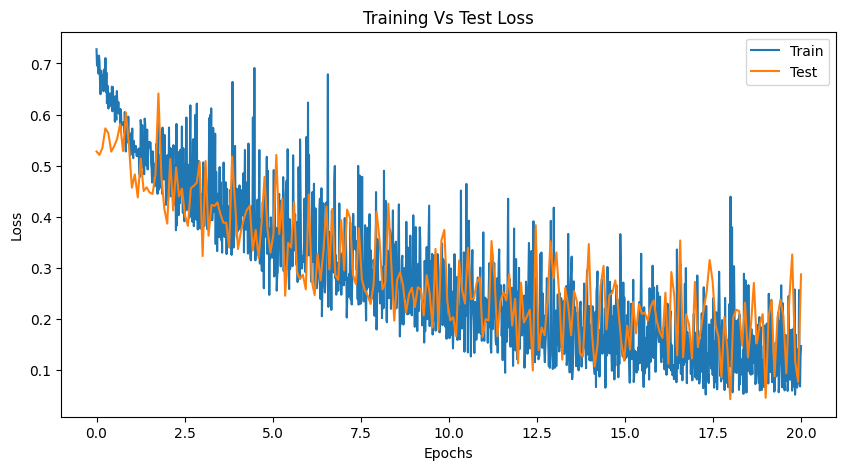

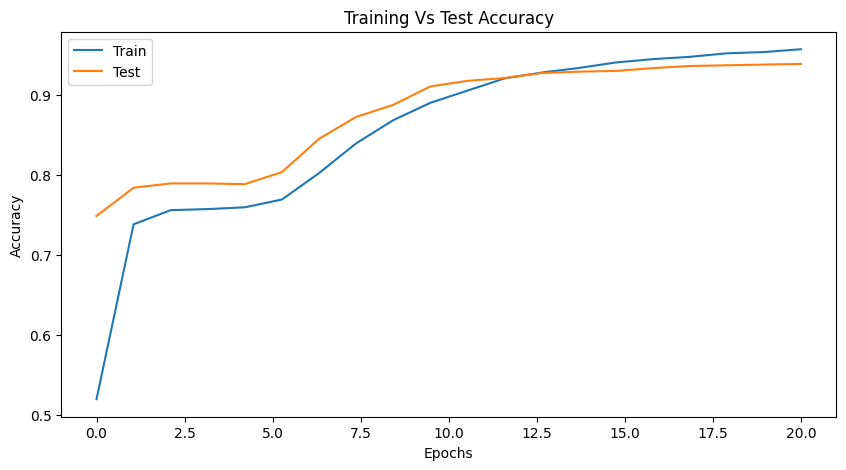

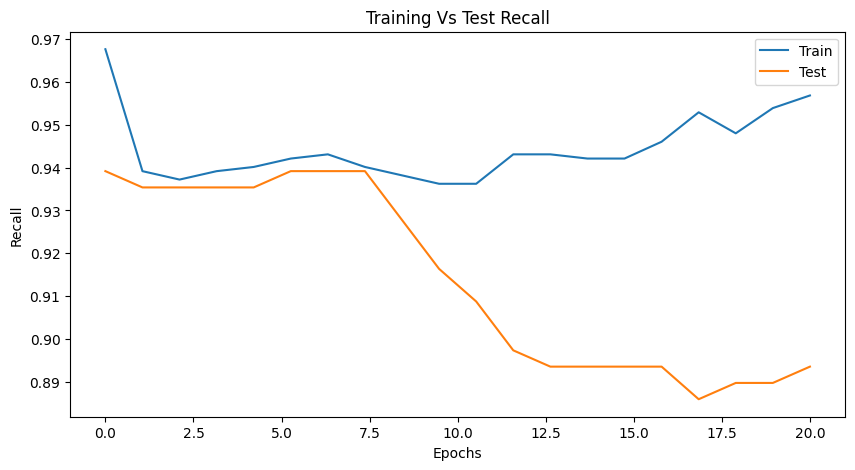

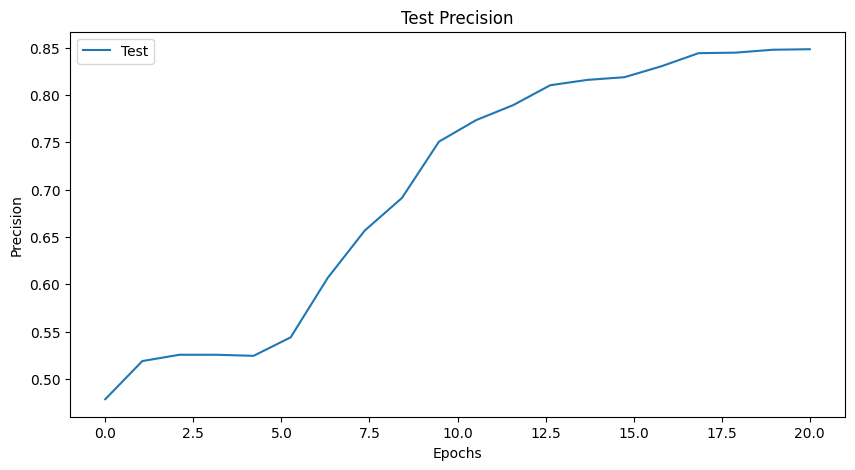

In [ ]:
model3 = Conv1DClassifier(embedding_matrix, 300).to(device)
model = Conv1DClassifier(embedding_matrix, 300).to(device)
model.load_state_dict(model3.state_dict())

weights = torch.tensor([1.0, 4.0], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-4)

model = conv_super(300, embedding_matrix).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train, test = train_test_split(file, test_size= 0.2, random_state=42)
train_model(model, criterion, train, test, num_epochs = 20)


In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 900.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, LogitsProcessorList
device = "cuda"

In [ ]:
import gc
gc.collect()

from numba import cuda
device = cuda.get_current_device()
device.reset()


print(f"Свободно памяти CUDA: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Свободно памяти CUDA: 12346.00 MB


In [ ]:
device = "cuda"

In [ ]:

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model_llm = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",    device_map=device,
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    output_hidden_states=True
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model_llm = AutoModelForCausalLM.from_pretrained(
    "tiiuae/Falcon3-3B-Instruct",    device_map=device,
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    output_hidden_states=True
)
tokenizer = AutoTokenizer.from_pretrained("tiiuae/Falcon3-3B-Instruct")

config.json:   0%|          | 0.00/658 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, LogitsProcessorList
device = "cuda"

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model_llm = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-4-mini-instruct",    device_map=device,
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    output_hidden_states=True
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-4-mini-instruct")

config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
spam_for_test = file.loc[file["result"] == 1][0:150]
nonspam_for_not_test = file.loc[file["result"] == 0][0:150]
test_dataset = pd.concat([spam_for_test, nonspam_for_not_test], ignore_index=True).reset_index(drop = True)

file_edited = file.drop(spam_for_test.index)
file_edited = file_edited.drop(nonspam_for_not_test.index)
file_edited = file_edited.reset_index(drop = True)
print(file_edited)

file_labeled = file_edited.iloc[0:300]
print(file_labeled)

file_edited = file_edited.drop(file_labeled.index).reset_index(drop = True)
print(file_edited)


      result                                             emails  \
0          0                 Haha awesome, be there in a minute   
1          0  Have you got Xmas radio times. If not i will g...   
2          0  I jus reached home. I go bathe first. But my s...   
3          0  I'm sorry. I've joined the league of people th...   
4          0              Hi :)finally i completed the course:)   
...      ...                                                ...   
5356       1  you need vicodin . you get it here . no need t...   
5357       1  early christmas gift\ncomplimentary 3 - sessio...   
5358       1  tue , 16 nov 2004 07 : 19 : 58 + 0300\nmime - ...   
5359       1  hi !\nwe have a new product that we offer to y...   
5360       1  hi again ,\ni sent an email 2 days ago and i w...   

                                         transform_text  
0                                   haha awesome minute  
1                              got xmas radio times get  
2     jus reached hom

In [ ]:
file_edited["emails"] = file_edited["emails"].apply(lambda text: text[:400] if isinstance(text, str) else text)
file_edited["transform_text"] = file_edited["transform_text"].apply(lambda text: text[:400] if isinstance(text, str) else text)

In [ ]:
file_edited = file_edited.drop_duplicates(subset=['emails']).reset_index(drop=True)
file_edited = file_edited.drop_duplicates(subset=['transform_text']).reset_index(drop=True)

In [ ]:
def gen_ansewers_for_texts(func_for_gen_responce, dataset, size_of_batch):

  model_llm.eval()
  indxs = np.arange(len(dataset))
  for start in range(0, len(indxs), size_of_batch):
      texts = dataset["emails"].iloc[indxs[start:start + size_of_batch]]
      yield func_for_gen_responce(texts)

answers = []
with torch.inference_mode():
  for answer in gen_ansewers_for_texts(gen_response, file_edited, 64):
      answers.append(answer)
      gc.collect()
      torch.cuda.empty_cache()

  answers_from_llm = np.hstack(answers[:])

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [ ]:
print(len(answers))

95


In [ ]:
np.save('/content/drive/MyDrive/answers_from_llm_qwen_2.npy', answers_from_llm)

In [ ]:
loaded_answers = np.load('/content/drive/MyDrive/answers_from_llm_qwen_2_new_set.npy', allow_pickle=True)


In [ ]:

loaded_answers = list(map(int, loaded_answers))


In [ ]:
print(list(map(int, loaded_answers)))
print(len(loaded_answers))

[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [ ]:

file_edited_with_answers_from_llm = file_edited.copy()
file_edited_with_answers_from_llm.result = loaded_answers
file_edited_with_answers_from_llm

,result,emails,transform_text
0,0,Ok give me 5 minutes I think I see her. BTW yo...,ok give minutes think see btw alibi cutting ha...
1,1,Imagine you finally get to sink into that bath...,imagine finally get sink bath put paces maybe ...
2,0,"Hurry up, I've been weed-deficient for like th...",hurry weed deficient like three days
3,1,"Sure, if I get an acknowledgement from you tha...",sure get acknowledgement astoundingly tactless...
4,0,Ok. Every night take a warm bath drink a cup o...,ok every night take warm bath drink cup milk s...
...,...,...,...
5045,1,you need vicodin . you get it here . no need t...,need vicodin get need wait longer unique chanc...
5046,1,early christmas gift\ncomplimentary 3 - sessio...,early christmas gift complimentary session con...
5047,1,"tue , 16 nov 2004 07 : 19 : 58 + 0300\nmime - ...",tue nov mime version content type text html ch...
5048,1,hi !\nwe have a new product that we offer to y...,hi new product offer c l soft tabs cialis soft...


In [ ]:
file["result"].value_counts()

,count
result,
0,4379
1,1282


In [ ]:
print(list(map(int, answers_from_llm)))



NameError: name 'answers_from_llm' is not defined

In [ ]:
(list(map(int, loaded_answers)) == file_edited.result.values).sum()/len(file_edited.result.values)

np.float64(0.6887128712871287)

In [ ]:
print(sum(list(map(int, answers_from_llm))))

NameError: name 'answers_from_llm' is not defined

In [ ]:
print(sum(file_edited.result.values))

1711


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(file_edited.result.values, list(map(int, file_edited_with_answers_from_llm.result.values)))

array([[2726, 1203],
       [ 369,  752]])

In [ ]:
from torch.nn import functional as F
import gc

class OnlyZeroOneProcessor():
    def __call__(self, input_ids, scores):
        allowed_tokens = [tokenizer.convert_tokens_to_ids("0"), tokenizer.convert_tokens_to_ids("1")]
        mask = torch.full_like(scores, float("-inf"))
        mask[:, allowed_tokens] = scores[:, allowed_tokens]
        return mask

def gen_response(prompts):

   with torch.inference_mode():

        model_llm.eval()
        tokenizer.padding_side = 'left'
        messages_list = [
            [
                {"role": "system", "content": "You are a classification model. You are ONLY allowed to respond with numbers. Words are STRICTLY FORBIDDEN. Answer '1' for spam and '0' for not spam. If you include anything other than '1' or '0', it is an error. My sentence- "
},
                {"role": "user", "content": prompt}
            ]
            for prompt in prompts
        ]

        texts = [tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, max_length=100) for messages in messages_list]

        inputs = tokenizer(texts, return_tensors="pt", padding=True, max_length=100).to(device)


        outputs = model_llm.generate(
              inputs.input_ids,
              max_new_tokens=1,
              temperature = 0.5,
              logits_processor=LogitsProcessorList([OnlyZeroOneProcessor()])
          )

        generated_ids = [
            output_ids[len(input_ids):] for output_ids, input_ids in zip(outputs, inputs.input_ids)
        ]

        prompt_inputs = tokenizer.batch_decode(generated_ids, return_tensors="pt", add_special_tokens=False)
        del inputs
        del outputs
        torch.cuda.empty_cache()
        gc.collect()

        return prompt_inputs


def gen_response_with_probs_batch(model_llm, prompts, top_k=1):

  with torch.no_grad():
    tokenizer.padding_side = 'left'
    messages_list = [
        [
            {"role": "system", "content": "You are a precise spam detector that strongly prioritizes catching spam but also avoids false alarms. You must classify anything clearly promotional, urgent, deceptive, or unsolicited as spam — respond with '1'. However, if a message seems harmless, personal, or informative, respond with '0'. Be cautious, but not paranoid. If there's significant doubt, err on the side of caution, but do not mark normal human messages as spam. You must output only '1' or '0'. No words. My sentence - "},
            {"role": "user", "content":  prompt}
        ]
        for prompt in prompts
    ]


    texts = [tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True) for messages in messages_list]


    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)


    outputs = model_llm.generate(
        inputs.input_ids,
        max_new_tokens=1,
        return_dict_in_generate=True,
        output_scores=True,
        temperature= 0.5 ,
        logits_processor=LogitsProcessorList([OnlyZeroOneProcessor()])
    )


    logits = outputs.scores[0]
    top_k_probs, top_k_token_ids = torch.topk(logits, k=top_k, dim=-1)
    top_k_tokens = tokenizer.batch_decode(top_k_token_ids)
    top_k_tokens = list(map(int, top_k_tokens))

    padded_probs = [
        F.pad(arr, (rule, 1-rule), mode='constant',value= 1 - arr[0])
        for arr, rule in zip(top_k_probs, top_k_tokens)
    ]

    padded_probs = [arr.tolist() for arr in padded_probs]

    return  torch.tensor(padded_probs)


batch = make_batch(file[0:150])
tokens = gen_response(file[0:32].emails)
print(f"Tokens: {tokens}")

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Tokens: ['0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [ ]:
file[0:32].result

,result
0,0
1,0
2,1
3,0
4,0
5,1
6,0
7,0
8,1
9,1


In [ ]:
sum(map(int, tokens))

5

In [ ]:
tokens = gen_response_with_probs_batch(model_llm, file[0:150].emails)
print(f"Tokens: {tokens}")

Tokens: tensor([[ 6.0476, -5.0476],
        [ 5.9048, -4.9048],
        [-7.5238,  8.5238],
        [ 6.0476, -5.0476],
        [ 6.1429, -5.1429],
        [-6.2381,  7.2381],
        [ 6.0476, -5.0476],
        [ 6.8571, -5.8571],
        [-5.9524,  6.9524],
        [ 7.0476, -6.0476],
        [ 6.6190, -5.6190],
        [-7.6667,  8.6667],
        [-7.5714,  8.5714],
        [ 7.2381, -6.2381],
        [ 5.7143, -4.7143],
        [ 6.8095, -5.8095],
        [ 5.9762, -4.9762],
        [ 6.3333, -5.3333],
        [ 6.2857, -5.2857],
        [ 7.9048, -6.9048],
        [ 6.0000, -5.0000],
        [ 6.1429, -5.1429],
        [ 5.9762, -4.9762],
        [ 6.2857, -5.2857],
        [ 6.0238, -5.0238],
        [ 6.5714, -5.5714],
        [ 5.7619, -4.7619],
        [ 6.8095, -5.8095],
        [ 6.1429, -5.1429],
        [ 6.0952, -5.0952],
        [ 6.5714, -5.5714],
        [ 8.0476, -7.0476],
        [ 3.8810, -2.8810],
        [ 6.2381, -5.2381],
        [ 6.4762, -5.4762],
        [ 6.

[0.94, 0.9433333333333334, 0.9466666666666667, 0.9533333333333334, 0.9333333333333333, 0.94, 0.9333333333333333, 0.94, 0.94, 0.9266666666666666]
0.9396666666666664
[0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.9266666666666666, 0.9066666666666666, 0.9066666666666666, 0.9066666666666666, 0.9066666666666666]
0.9226666666666666
[0.9459459459459459, 0.9523809523809523, 0.958904109589041, 0.9722222222222222, 0.9276315789473685, 0.952054794520548, 0.9577464788732394, 0.9714285714285714, 0.9714285714285714, 0.9444444444444444]
0.9554187669780904


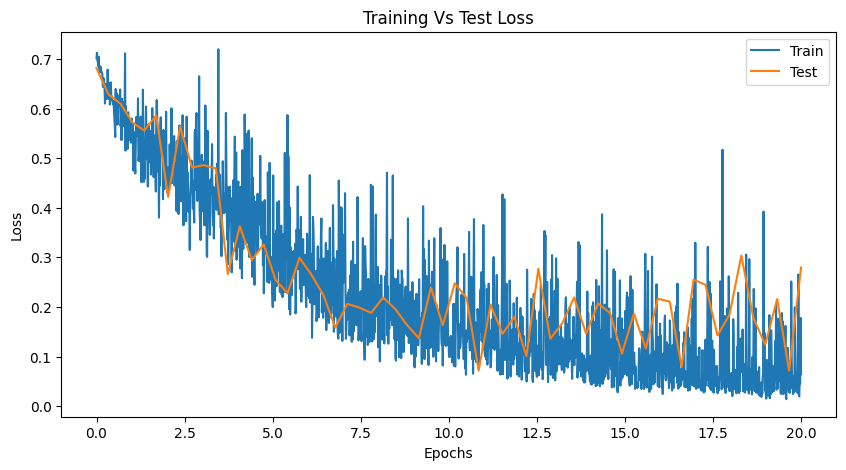

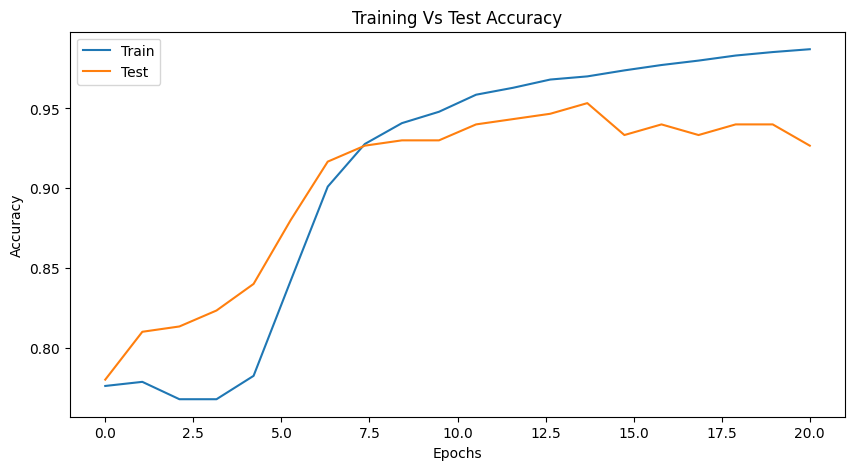

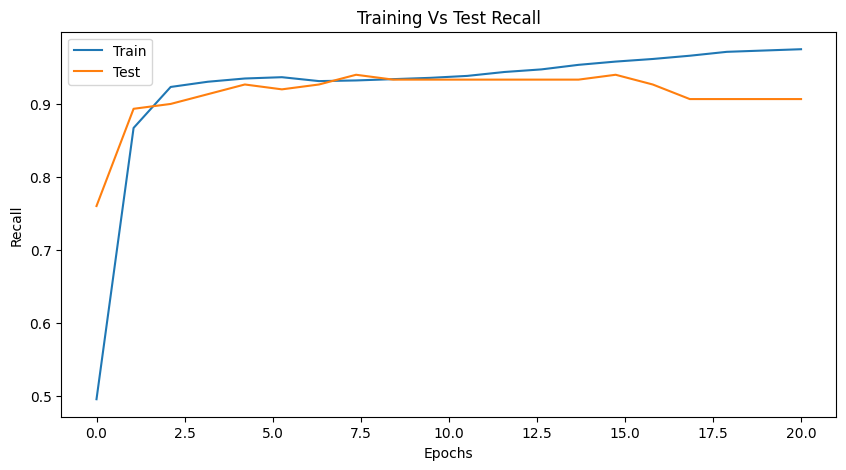

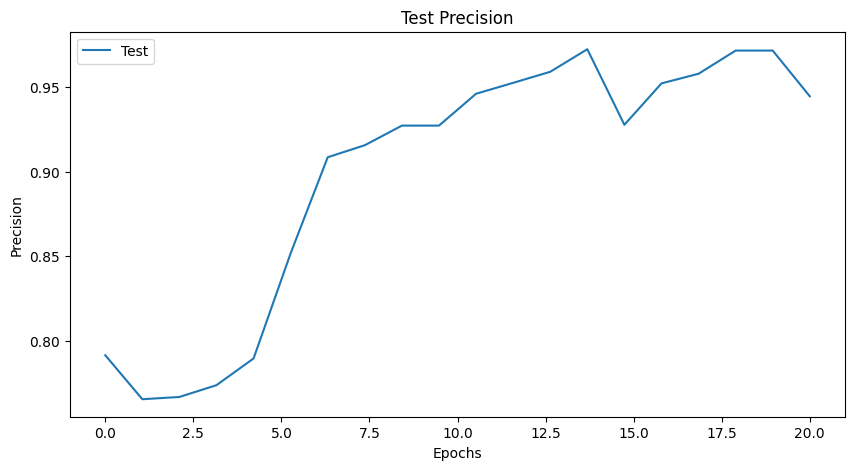

In [ ]:
model3 = Conv1DClassifier(embedding_matrix, 300).to(device)
model2 = Conv1DClassifier(embedding_matrix, 300).to(device)
model2.load_state_dict(model3.state_dict())

model3 = TextClassifierWithLSTM(embedding_matrix, 300, 30, 1).to(device)
weights = torch.tensor([1.0, 4.0], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-4)
train_model(model3, criterion, file_edited, test_dataset)




[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
0.5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0


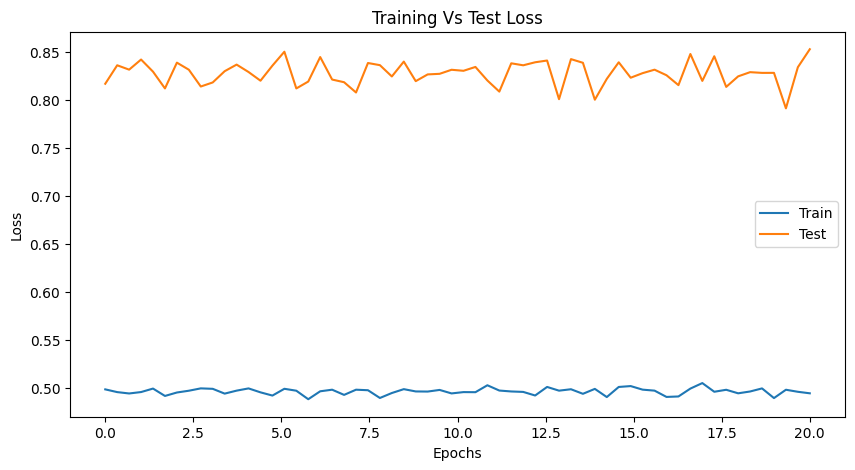

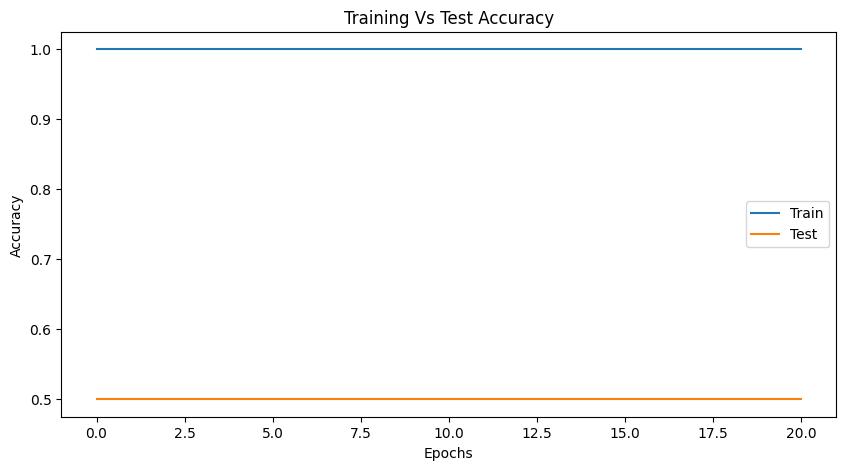

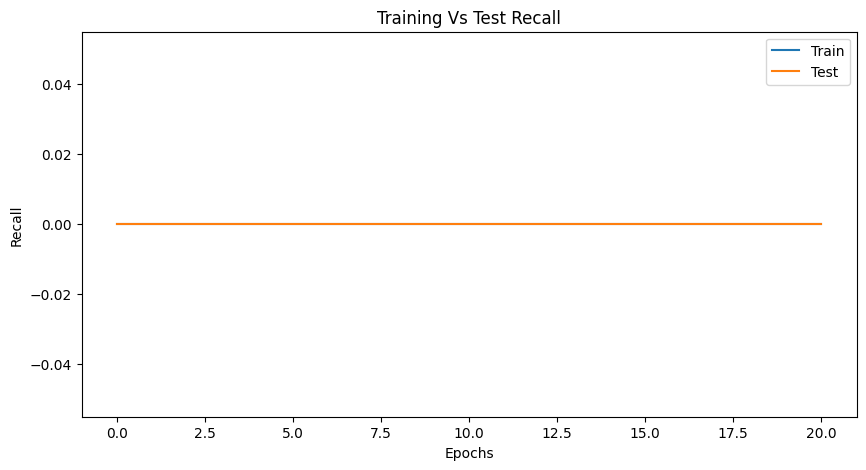

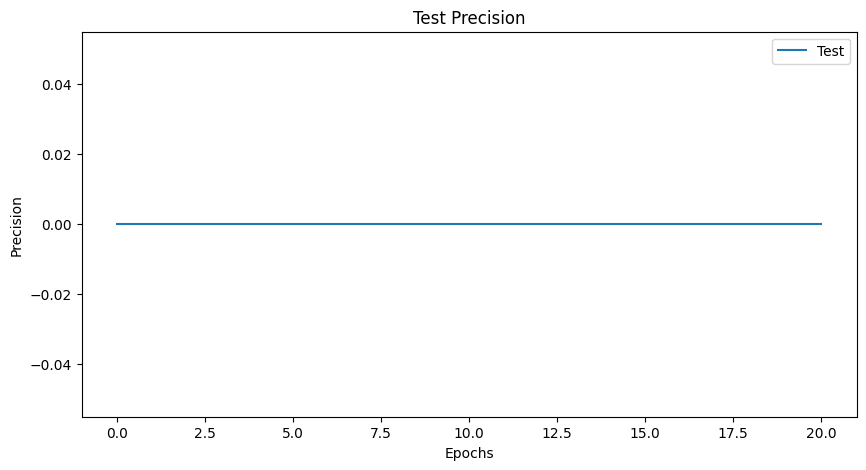

In [ ]:
model = conv_super(300, embedding_matrix).to(device)
labeled_data = file_labeled[:150]
train_model(model, criterion, labeled_data, test_dataset)


In [ ]:

drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/basic_super_conv_model.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = Conv1DClassifier(embedding_matrix, 300).to(device)

weights_path = '/content/drive/MyDrive/basic_conv_model.pt'
model.load_state_dict(torch.load(weights_path))
model.eval()

print("Веса успешно загружены!")

Веса успешно загружены!


In [ ]:
def train_knowledge_distillation(teacher, model, epochs, T, soft_target_loss_weight, ce_loss_weight, dataset, device, batch_size = 64, size_of_test = 0.2):

    weights = torch.tensor([1.0, 4.0], device=device)
    ce_loss = nn.CrossEntropyLoss(weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    train, test = train_test_split(dataset, test_size=size_of_test, random_state=42)


    teacher.eval()
    test_acc_logger = []
    test_recall_logger = []
    training_loss_logger = []
    training_acc_logger = []
    training_recall_logger = []


    for epoch in range(epochs):
        running_loss = 0.0

        train_acc = 0
        test_acc = 0
        steps = 0
        TP = 0
        FN = 0
        recall = 0
        model.train()

        for batch, data_slice in (iterate_minibatches(train, batch_size, shuffle=True, device=device)):

                bs = batch["result"].size(0)
                student_logits = model(batch["text"])


                optimizer.zero_grad()

                with torch.no_grad():
                    teacher_logits = gen_response_with_probs_batch(data_slice.emails)


                soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1).to(device)
                soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1).to(device)

                soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)


                label_loss = ce_loss(student_logits, batch["result"])


                loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                training_loss_logger.append(loss.item())
                train_acc += (torch.max(student_logits, 1)[1] == batch["result"]).int().sum().item()
                steps += bs
                TP += ((torch.max(student_logits, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                FN += ((torch.max(student_logits, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()


        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / steps}")

        train_acc = (train_acc/steps)
        training_acc_logger.append(train_acc)

        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        training_recall_logger.append(recall)

        model.eval()
        steps = 0
        test_acc = 0
        TP = 0
        FN = 0
        recall = 0


        with torch.no_grad():
            for batch, _ in  (iterate_minibatches(test, batch_size=100, device=device)):

                bs = batch["result"].size(0)
                pred = model(batch["text"])
                loss = criterion(pred, batch["result"])

                test_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
                steps += bs

                TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()


            test_acc_logger.append(test_acc/steps)
            print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {test_acc/steps}")
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
            print(f"Epoch {epoch+1}/{epochs}, Test Recall: {recall}")
            test_recall_logger.append(recall)





    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, epoch, len(training_acc_logger)), training_acc_logger)
    plt.plot(np.linspace(0, epoch, len(test_acc_logger)), test_acc_logger)
    plt.legend(["Train", "Test"])
    plt.title("Training Vs Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")


    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, epoch, len(training_recall_logger)), training_recall_logger)
    plt.plot(np.linspace(0, epoch, len(test_recall_logger)), test_recall_logger)
    plt.legend(["Train", "Test"])
    plt.title("Training Vs Test Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")

In [ ]:
def choose_indexes_with_random(dataset, size):
  indexes = np.arange(len(dataset))
  indexes = np.random.permutation(indexes)
  return indexes[:size]


def extraction_probs_from_llm(model, data):

    dictionary = {}
    with torch.no_grad():
      probs = gen_response_with_probs_batch(model, data.emails.values)
      for prob, index in zip(probs, data.index):
        dictionary[index] = prob

    return dictionary

def train_knowledge_distillation_second_version(teacher, model, epochs, T, soft_target_loss_weight, ce_loss_weight, train_for_distil, test_for_distil, device, num_iterations = 200, num_of_samples = 15, batch_size = 64, size_of_test = 0.2):

    weights = torch.tensor([1.0, 4.0], device=device)
    ce_loss = nn.CrossEntropyLoss(weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    train = train_for_distil.copy()
    test = test_for_distil

    teacher.eval()
    test_acc_logger = []
    test_recall_logger = []
    training_loss_logger = []
    test_precision_logger = []

    for iteration in range(num_iterations):

      indexes_of_objects = choose_indexes_with_random(train,  num_of_samples)

      objects = train.iloc[indexes_of_objects].reset_index(drop=True)

      train = train.drop(indexes_of_objects)
      train = train.reset_index(drop=True)

      soft_targets_dict = extraction_probs_from_llm(teacher, objects)
      running_loss = 0.0

      for epoch in range(epochs):

          steps = 0.0
          model.train()
          for batch, data_slice in (iterate_minibatches(objects, batch_size, shuffle= True, device=device)):

                bs = batch["result"].size(0)
                student_logits = model(batch["text"])

                teacher_logits = [soft_targets_dict[idx].tolist() for idx in data_slice.index]
                teacher_logits = torch.tensor(teacher_logits)


                optimizer.zero_grad()
                soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1).to(device)
                soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1).to(device)

                soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)


                label_loss = ce_loss(student_logits, batch["result"])


                loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                training_loss_logger.append(loss.item())
                steps += bs


          print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / steps}")



      model.eval()
      steps = 0
      test_acc = 0
      TP = 0
      FN = 0
      FP = 0
      recall = 0
      precision = 0

      with torch.no_grad():
            for batch, _ in  (iterate_minibatches(test, batch_size=100, device=device)):

                bs = batch["result"].size(0)
                pred = model(batch["text"])
                loss = criterion(pred, batch["result"])

                test_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
                steps += bs

                TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()
                FP += ((torch.max(pred, 1)[1]  == 1) & (batch["result"] == 0)).sum().item()

            test_acc_logger.append(test_acc/steps)
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
            test_recall_logger.append(recall)
            test_precision_logger.append(precision)





    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, num_iterations, len(test_acc_logger)), test_acc_logger)
    plt.legend(["Test"])
    plt.title("Test Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")


    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, num_iterations, len(test_recall_logger)), test_recall_logger)
    plt.legend(["Test"])
    plt.title("Test Recall")
    plt.xlabel("Iterations")
    plt.ylabel("Recall")


    plt.figure(figsize=(10, 5))
    plt.plot(np.linspace(0, num_iterations, len(test_precision_logger)), test_precision_logger)
    plt.legend(["Test"])
    plt.title("Test Precision")
    plt.xlabel("Iterations")
    plt.ylabel("Precision")


    print(test_acc_logger[-10:])
    print(sum(test_acc_logger[-30:]) / 30)
    print(test_recall_logger[-10:])
    print(sum(test_recall_logger[-30:]) / 30)
    print(test_precision_logger[-10:])
    print(sum(test_precision_logger[-30:]) / 30)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = Conv1DClassifier(embedding_matrix, 300).to(device)
train_knowledge_distillation(model_llm, model, 5,  T=1, soft_target_loss_weight=0.3, ce_loss_weight=0.85, dataset= file[:4000], device=device)

NameError: name 'train_knowledge_distillation' is not defined

In [ ]:
model = Conv1DClassifier(embedding_matrix, 300).to(device)

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.046874494552612306
Epoch 2/5, Loss: 0.0930946159362793
Epoch 3/5, Loss: 0.1387133502960205
Epoch 4/5, Loss: 0.1837819719314575
Epoch 5/5, Loss: 0.2283441209793091


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0393296480178833
Epoch 2/5, Loss: 0.07810157060623169
Epoch 3/5, Loss: 0.11616855382919311
Epoch 4/5, Loss: 0.15348302602767944
Epoch 5/5, Loss: 0.1900451159477234


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03621046543121338
Epoch 2/5, Loss: 0.07146820068359375
Epoch 3/5, Loss: 0.10577216148376464
Epoch 4/5, Loss: 0.1391625213623047
Epoch 5/5, Loss: 0.1716966962814331


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05175911903381348
Epoch 2/5, Loss: 0.10377411842346192
Epoch 3/5, Loss: 0.15585315704345704
Epoch 4/5, Loss: 0.20783740520477295
Epoch 5/5, Loss: 0.2595982980728149


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.055687389373779296
Epoch 2/5, Loss: 0.11104485034942627
Epoch 3/5, Loss: 0.16584278106689454
Epoch 4/5, Loss: 0.2199073076248169
Epoch 5/5, Loss: 0.27310120582580566


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05074110507965088
Epoch 2/5, Loss: 0.10101744174957275
Epoch 3/5, Loss: 0.15080631732940675
Epoch 4/5, Loss: 0.20011209964752197
Epoch 5/5, Loss: 0.24893791675567628


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05069543838500976
Epoch 2/5, Loss: 0.10080633163452149
Epoch 3/5, Loss: 0.15027300834655763
Epoch 4/5, Loss: 0.19905391216278076
Epoch 5/5, Loss: 0.24713757038116455


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.047877225875854496
Epoch 2/5, Loss: 0.09521930694580077
Epoch 3/5, Loss: 0.14198373794555663
Epoch 4/5, Loss: 0.18814396858215332
Epoch 5/5, Loss: 0.23368250370025634


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04673864841461182
Epoch 2/5, Loss: 0.09335685253143311
Epoch 3/5, Loss: 0.1398232698440552
Epoch 4/5, Loss: 0.18611330509185792
Epoch 5/5, Loss: 0.2322029447555542


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.047480173110961914
Epoch 2/5, Loss: 0.09492818832397461
Epoch 3/5, Loss: 0.14227468013763428
Epoch 4/5, Loss: 0.18946467876434325
Epoch 5/5, Loss: 0.2364550018310547


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.048230762481689456
Epoch 2/5, Loss: 0.09639833450317382
Epoch 3/5, Loss: 0.1444500970840454
Epoch 4/5, Loss: 0.19234297275543213
Epoch 5/5, Loss: 0.24004817008972168


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04467430114746094
Epoch 2/5, Loss: 0.08928796291351318
Epoch 3/5, Loss: 0.1337956428527832
Epoch 4/5, Loss: 0.17815868854522704
Epoch 5/5, Loss: 0.22234917163848877


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.051165561676025394
Epoch 2/5, Loss: 0.10222651481628418
Epoch 3/5, Loss: 0.153108434677124
Epoch 4/5, Loss: 0.20375085830688477
Epoch 5/5, Loss: 0.25410929679870603


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04483180999755859
Epoch 2/5, Loss: 0.0896343994140625
Epoch 3/5, Loss: 0.13431490898132326
Epoch 4/5, Loss: 0.17878758430480957
Epoch 5/5, Loss: 0.22298776626586914


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.044099369049072266
Epoch 2/5, Loss: 0.08813279151916503
Epoch 3/5, Loss: 0.13203859329223633
Epoch 4/5, Loss: 0.17576536178588867
Epoch 5/5, Loss: 0.21927052974700928


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0437891674041748
Epoch 2/5, Loss: 0.08747967720031738
Epoch 3/5, Loss: 0.1309930419921875
Epoch 4/5, Loss: 0.1742605447769165
Epoch 5/5, Loss: 0.2172340726852417


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.044515743255615234
Epoch 2/5, Loss: 0.08883395195007324
Epoch 3/5, Loss: 0.1328565263748169
Epoch 4/5, Loss: 0.1765117645263672
Epoch 5/5, Loss: 0.21974728107452393


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05019277572631836
Epoch 2/5, Loss: 0.10039277076721191
Epoch 3/5, Loss: 0.1504833221435547
Epoch 4/5, Loss: 0.20036717414855956
Epoch 5/5, Loss: 0.24996548175811767


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.044794950485229496
Epoch 2/5, Loss: 0.08953912734985352
Epoch 3/5, Loss: 0.13419580459594727
Epoch 4/5, Loss: 0.17873798847198485
Epoch 5/5, Loss: 0.22313813209533692


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04793471336364746
Epoch 2/5, Loss: 0.09572999477386475
Epoch 3/5, Loss: 0.14332902431488037
Epoch 4/5, Loss: 0.19068596363067628
Epoch 5/5, Loss: 0.23776574611663817


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.043649635314941405
Epoch 2/5, Loss: 0.08721749305725097
Epoch 3/5, Loss: 0.13060482025146483
Epoch 4/5, Loss: 0.1737349510192871
Epoch 5/5, Loss: 0.21653849124908447


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04057005882263184
Epoch 2/5, Loss: 0.0810451316833496
Epoch 3/5, Loss: 0.12134293079376221
Epoch 4/5, Loss: 0.1613947057723999
Epoch 5/5, Loss: 0.20115214347839355


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.045996150970458984
Epoch 2/5, Loss: 0.09187592506408691
Epoch 3/5, Loss: 0.1375439739227295
Epoch 4/5, Loss: 0.1829345417022705
Epoch 5/5, Loss: 0.22800155639648437


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.045531816482543945
Epoch 2/5, Loss: 0.0909921407699585
Epoch 3/5, Loss: 0.13632452487945557
Epoch 4/5, Loss: 0.18147725105285645
Epoch 5/5, Loss: 0.22641058921813964


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04844780921936035
Epoch 2/5, Loss: 0.0967882251739502
Epoch 3/5, Loss: 0.1449393081665039
Epoch 4/5, Loss: 0.19284022808074952
Epoch 5/5, Loss: 0.24044555187225342


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04865158081054687
Epoch 2/5, Loss: 0.09723923206329346
Epoch 3/5, Loss: 0.14569334506988527
Epoch 4/5, Loss: 0.19396062850952148
Epoch 5/5, Loss: 0.24200429439544677


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.044069652557373044
Epoch 2/5, Loss: 0.08810482025146485
Epoch 3/5, Loss: 0.13190268516540526
Epoch 4/5, Loss: 0.17529874801635742
Epoch 5/5, Loss: 0.21815237998962403


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04736249446868897
Epoch 2/5, Loss: 0.09481300830841065
Epoch 3/5, Loss: 0.14226769924163818
Epoch 4/5, Loss: 0.18964996814727783
Epoch 5/5, Loss: 0.23688728332519532


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04512500762939453
Epoch 2/5, Loss: 0.09013272285461425
Epoch 3/5, Loss: 0.13494256019592285
Epoch 4/5, Loss: 0.17948929309844971
Epoch 5/5, Loss: 0.22371837139129638


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04736196517944336
Epoch 2/5, Loss: 0.09463250160217285
Epoch 3/5, Loss: 0.14174388885498046
Epoch 4/5, Loss: 0.1886445999145508
Epoch 5/5, Loss: 0.23529740333557128


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04468220710754395
Epoch 2/5, Loss: 0.08924527168273926
Epoch 3/5, Loss: 0.13362794876098633
Epoch 4/5, Loss: 0.17777997970581055
Epoch 5/5, Loss: 0.22166409492492675


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04464940071105957
Epoch 2/5, Loss: 0.08922559261322022
Epoch 3/5, Loss: 0.13365107536315918
Epoch 4/5, Loss: 0.17786620140075685
Epoch 5/5, Loss: 0.2218191957473755


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.053211092948913574
Epoch 2/5, Loss: 0.10634048461914063
Epoch 3/5, Loss: 0.15920422554016114
Epoch 4/5, Loss: 0.21167134284973144
Epoch 5/5, Loss: 0.263648042678833


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.045338163375854494
Epoch 2/5, Loss: 0.09064855575561523
Epoch 3/5, Loss: 0.13585485458374025
Epoch 4/5, Loss: 0.18089157104492187
Epoch 5/5, Loss: 0.22569875717163085


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0485630989074707
Epoch 2/5, Loss: 0.09701328277587891
Epoch 3/5, Loss: 0.14529351234436036
Epoch 4/5, Loss: 0.19334930896759034
Epoch 5/5, Loss: 0.2411455774307251


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04605539321899414
Epoch 2/5, Loss: 0.09208104133605957
Epoch 3/5, Loss: 0.13796670913696288
Epoch 4/5, Loss: 0.18361518383026124
Epoch 5/5, Loss: 0.22894777297973634


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04684779167175293
Epoch 2/5, Loss: 0.09365460872650147
Epoch 3/5, Loss: 0.1403731346130371
Epoch 4/5, Loss: 0.18696293830871583
Epoch 5/5, Loss: 0.23339216709136962


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04475519180297852
Epoch 2/5, Loss: 0.08945227146148682
Epoch 3/5, Loss: 0.1340190601348877
Epoch 4/5, Loss: 0.17839725494384764
Epoch 5/5, Loss: 0.22253694534301757


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.045395002365112305
Epoch 2/5, Loss: 0.0907213830947876
Epoch 3/5, Loss: 0.13592867851257323
Epoch 4/5, Loss: 0.180978946685791
Epoch 5/5, Loss: 0.22583673954010008


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04936635971069336
Epoch 2/5, Loss: 0.09868462562561035
Epoch 3/5, Loss: 0.14785996913909913
Epoch 4/5, Loss: 0.19681257247924805
Epoch 5/5, Loss: 0.24547844886779785
[0.5666666666666667, 0.57, 0.5666666666666667, 0.5666666666666667, 0.57, 0.58, 0.5933333333333334, 0.6, 0.6, 0.6]
0.5365555555555556
[0.14, 0.15333333333333332, 0.14666666666666667, 0.15333333333333332, 0.16, 0.19333333333333333, 0.22666666666666666, 0.24, 0.24666666666666667, 0.25333333333333335]
0.08288888888888887
[0.9545454545454546, 0.92, 0.9166666666666666, 0.8846153846153846, 0.8888888888888888, 0.8529411764705882, 0.85, 0.8571428571428571, 0.8409090909090909, 0.8260869565217391]
0.7244324315449635


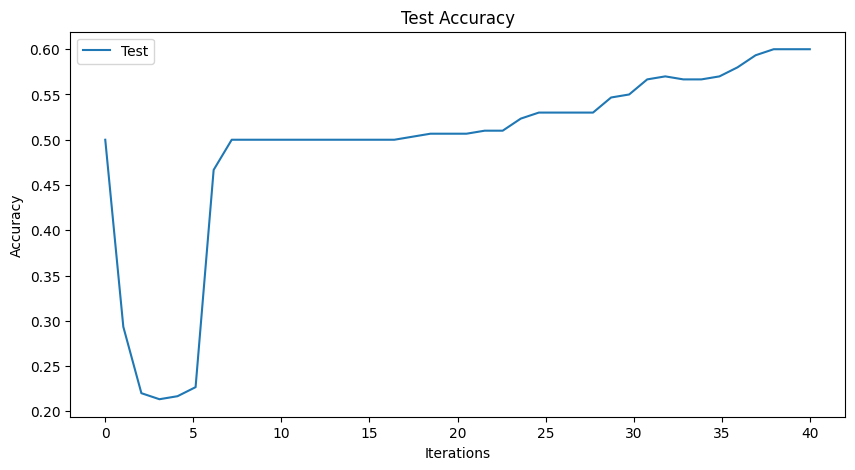

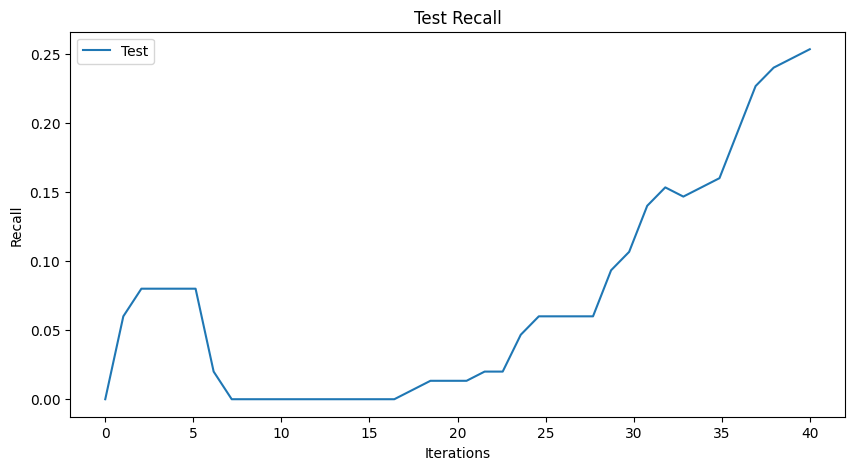

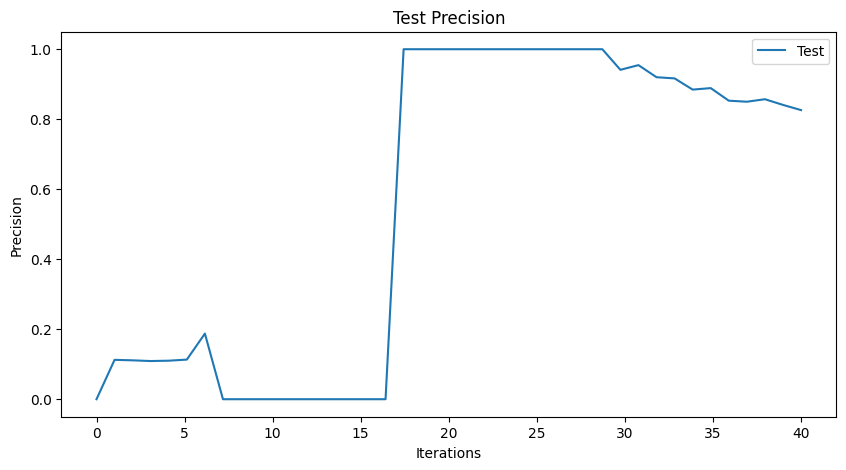

In [ ]:

weights_path = '/content/drive/MyDrive/basic_conv_model.pt'
model = Conv1DClassifier(embedding_matrix, 300).to(device)
model.load_state_dict(torch.load(weights_path))

train_knowledge_distillation_second_version(model_llm, model, 5,  T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, train_for_distil = file_edited_with_answers_from_llm, test_for_distil = test_dataset, device=device,  num_iterations = 40, num_of_samples = 25)

In [ ]:
del model_llm

In [ ]:
file_edited_with_answers_from_llm

,result,emails,transform_text
0,0,Yes! How is a pretty lady like you single?,yes pretty lady like single
1,1,Jay says that you're a double-faggot,jay says double faggot
2,1,What Today-sunday..sunday is holiday..so no wo...,today sunday sunday holiday work
3,0,Gudnite....tc...practice going on,gudnite tc practice going
4,0,I'll be late...,late
...,...,...,...
4967,1,This is the 2nd time we have tried 2 contact u...,nd time tried contact u u pound prize claim ea...
4968,0,Will Ì_ b going to esplanade fr home?,b going esplanade fr home
4969,1,"Pity, * was in mood for that. So...any other s...",pity mood suggestions
4970,1,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...


[0.8333333333333334, 0.8233333333333334, 0.81, 0.8066666666666666, 0.7966666666666666, 0.7966666666666666, 0.7933333333333333, 0.7933333333333333, 0.7933333333333333, 0.7866666666666666]
0.3638888888888889
[0.8666666666666667, 0.8866666666666667, 0.9, 0.9133333333333333, 0.9133333333333333, 0.92, 0.92, 0.9266666666666666, 0.9266666666666666, 0.9266666666666666]
0.33266666666666656
[0.8125, 0.7869822485207101, 0.7627118644067796, 0.7527472527472527, 0.7405405405405405, 0.7379679144385026, 0.7340425531914894, 0.7315789473684211, 0.7315789473684211, 0.7239583333333334]
0.31150793012612304


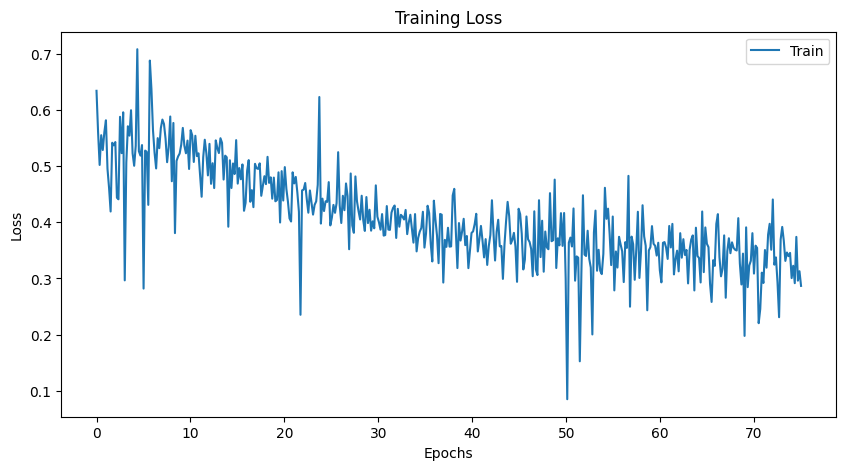

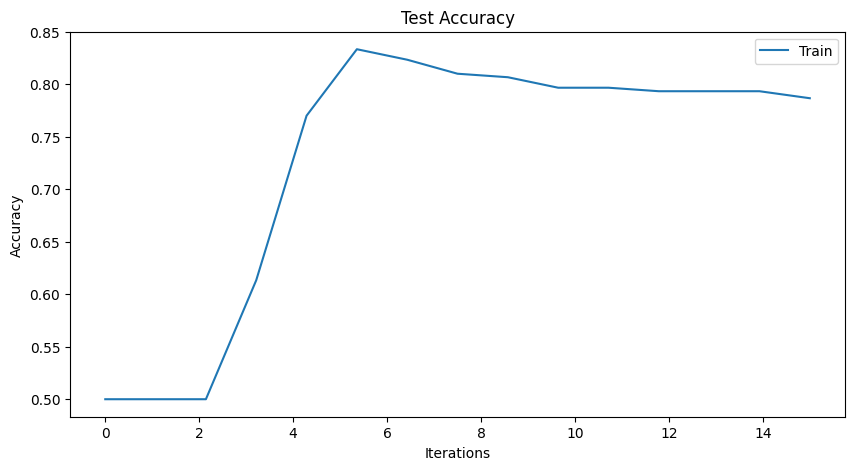

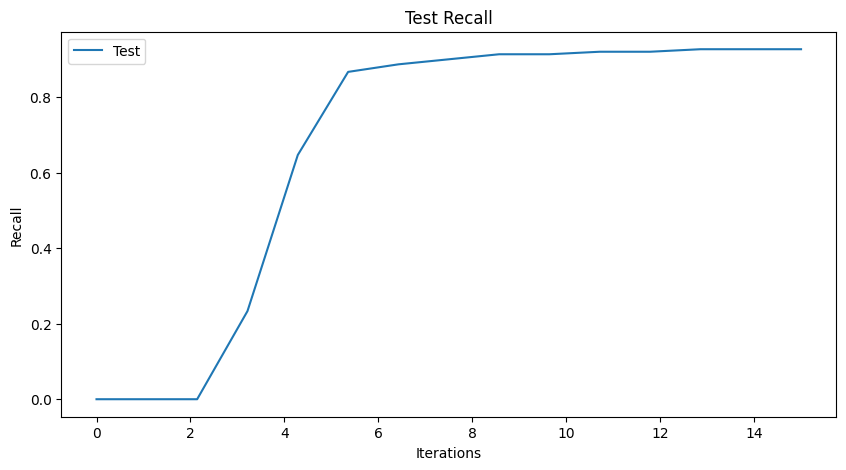

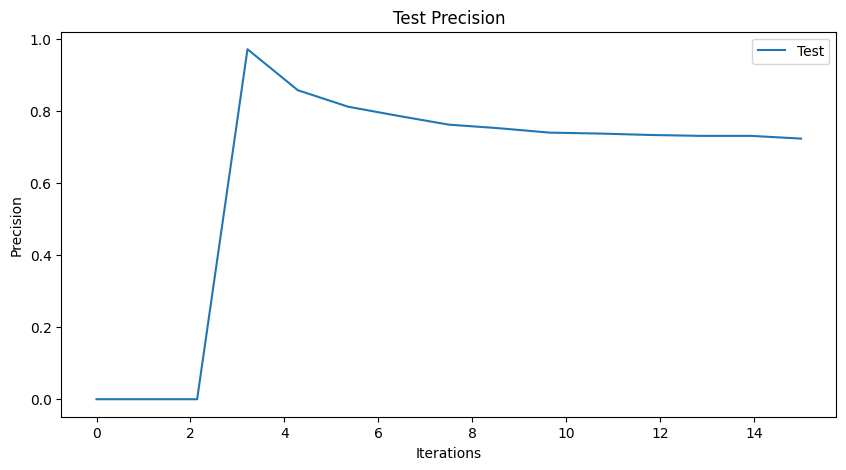

In [ ]:
#активное обучение
weights_path = '/content/drive/MyDrive/basic_super_conv_model.pt'
model = conv_super(300, embedding_matrix).to(device)
model.load_state_dict(torch.load(weights_path))

def calculate_entopy(model_output, k=1):

    model_output = torch.softmax(model_output, dim = -1)
    final_out = -model_output*torch.log(model_output)
    final_out = final_out.sum(dim=1)
    indices = torch.topk(final_out,k)[1]
    return indices


def func_with_grad(logits):

    probs = torch.softmax(logits, dim = -1)

    target_1 = torch.tensor([0], dtype=torch.long, device=device)
    target_2 = torch.tensor([1], dtype=torch.long, device=device)

    loss_1 = F.cross_entropy(logits.unsqueeze(0), target_1)
    loss_2 = F.cross_entropy(logits.unsqueeze(0), target_2)

    grad_1, = torch.autograd.grad(loss_1, logits)
    grad_2, = torch.autograd.grad(loss_2, logits)

    norm_of_grad1 = torch.norm(grad_1, p=2)
    norm_of_grad2 = torch.norm(grad_2, p=2)

    norms_of_grads = torch.stack((norm_of_grad1, norm_of_grad2))

    result = (probs*norms_of_grads).sum()

    return result

def most_uncertain_with_grad(model_output, k = 1 ):
    answer = torch.stack([func_with_grad(logit)  for logit in model_output])
    return torch.topk(answer,k)[1]


def calculate_uncertanity_1(model_output, k = 1):

    model_output = torch.softmax(model_output, dim = -1)
    tensor = torch.sort(model_output, dim = - 1, descending= True)[0]
    result = torch.vmap(lambda arr: arr[0] - arr[1])(tensor)
    indices = torch.topk(-result,k)[1]
    return indices

def calculate_uncertanity_2(model_output, k = 1):

    model_output = torch.softmax(model_output, dim = -1)
    model_output = torch.max(model_output, dim = -1)[0]
    result = 1 - model_output
    indices = torch.topk(result,k)[1]
    return indices





weights = torch.tensor([1.0, 4.0], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

training_loss_logger = []

test_acc_logger = []
test_recall_logger = []
test_precision_logger = []


unlabeled_data, test = (file_edited_with_answers_from_llm, test_dataset)
labeled_data = file_labeled[:150]


num_iterations = 15
batch_size = 64
num_epochs = 5
train_acc = 0



for iteration in range(num_iterations):

    batch_unlabeled = make_batch(unlabeled_data)
    model_outputs = model(batch_unlabeled["text"])
    indexes_of_uncertain_objects = calculate_entopy(model_outputs,  25)
    indexes_of_uncertain_objects = indexes_of_uncertain_objects.cpu().numpy()
    most_uncertain_objects = unlabeled_data.iloc[indexes_of_uncertain_objects].reset_index(drop=True)

    unlabeled_data = unlabeled_data.drop(indexes_of_uncertain_objects)
    unlabeled_data = unlabeled_data.reset_index(drop=True)
    labeled_data = pd.concat([labeled_data, most_uncertain_objects], ignore_index=True)

    for epoch in range(num_epochs):

        model.train()
        for batch, _ in (iterate_minibatches(labeled_data, batch_size, shuffle= True, device=device)):


            bs = batch["result"].size(0)
            pred = model(batch["text"])
            loss = criterion(pred, batch["result"])
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=0.01)
            optimizer.step()
            training_loss_logger.append(loss.item())



    steps = 0
    test_acc = 0
    TP = 0
    FN = 0
    FP = 0
    recall = 0

    model.eval()
    for batch, _ in (iterate_minibatches(test, batch_size=100, shuffle= False, device=device)):

                bs = batch["result"].size(0)
                pred = model(batch["text"])
                test_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
                steps += bs
                TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()
                FP += ((torch.max(pred, 1)[1]  == 1) & (batch["result"] == 0)).sum().item()


    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    test_recall_logger.append(recall)
    test_precision_logger.append(precision)
    test_acc_logger.append(test_acc/steps)




plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_epochs*num_iterations , len(training_loss_logger)), training_loss_logger)
plt.legend(["Train"])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_acc_logger)), test_acc_logger)
plt.legend(["Train"])
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")



plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_recall_logger)), test_recall_logger)
plt.legend(["Test"])
plt.title("Test Recall")
plt.xlabel("Iterations")
plt.ylabel("Recall")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_precision_logger)), test_precision_logger)
plt.legend(["Test"])
plt.title("Test Precision")
plt.xlabel("Iterations")
plt.ylabel("Precision")

print(test_acc_logger[-10:])
print(sum(test_acc_logger[-30:]) / 30)
print(test_recall_logger[-10:])
print(sum(test_recall_logger[-30:]) / 30)
print(test_precision_logger[-10:])
print(sum(test_precision_logger[-30:]) / 30)





In [ ]:
from transformers import AutoTokenizer, BertModel
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = BertModel.from_pretrained("prajjwal1/bert-tiny").to(device)

inputs = tokenizer("Hello, my dog is cute",  "Hello, World", return_tensors="pt").to(device)
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state


Using device: cuda


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

In [ ]:

from torch import nn
from torch.nn import functional as F

class BertClassifierForSpam(nn.Module):
  def __init__(self, model, tokenizer):
    super().__init__()
    self.bert = model
    self.tokenizer = tokenizer
    self.linear = nn.Linear(128, 2)

    for name, param in model.base_model.named_parameters():
        param.requires_grad = False

    for name, param in model.base_model.named_parameters():
        if "pooler" in name:
            param.requires_grad = True

  def forward(self, sentences):
    passed_sentences = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
    out = self.bert(**passed_sentences).pooler_output
    return self.linear(out)

model = BertClassifierForSpam(model, tokenizer).to(device)

In [ ]:
model(list(file_edited_with_answers_from_llm.emails[:5]))

tensor([[ 0.3947,  0.8369],
        [ 0.4500,  0.5216],
        [ 0.2307,  0.6877],
        [-0.2985,  0.9021],
        [ 0.0335,  0.8438]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
model(list(file_edited_with_answers_from_llm.emails[:5]))

tensor([[ 0.3947,  0.8369],
        [ 0.4500,  0.5216],
        [ 0.2307,  0.6877],
        [-0.2985,  0.9021],
        [ 0.0335,  0.8438]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
file_edited_with_answers_from_llm.result.values

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
#активное обучение для берта

def calculate_entopy(model_output, k=1):

    model_output = torch.softmax(model_output, dim = -1)
    final_out = -model_output*torch.log(model_output)
    final_out = final_out.sum(dim=1)
    indices = torch.topk(final_out,k)[1]
    return indices


def func_with_grad(logits):

    probs = torch.softmax(logits, dim = -1)

    target_1 = torch.tensor([0], dtype=torch.long, device=device)
    target_2 = torch.tensor([1], dtype=torch.long, device=device)

    loss_1 = F.cross_entropy(logits.unsqueeze(0), target_1)
    loss_2 = F.cross_entropy(logits.unsqueeze(0), target_2)

    grad_1, = torch.autograd.grad(loss_1, logits)
    grad_2, = torch.autograd.grad(loss_2, logits)

    norm_of_grad1 = torch.norm(grad_1, p=2)
    norm_of_grad2 = torch.norm(grad_2, p=2)

    norms_of_grads = torch.stack((norm_of_grad1, norm_of_grad2))

    result = (probs*norms_of_grads).sum()

    return result

def most_uncertain_with_grad(model_output, k = 1 ):
    answer = torch.stack([func_with_grad(logit)  for logit in model_output])
    return torch.topk(answer,k)[1]


def calculate_uncertanity_1(model_output, k = 1):

    model_output = torch.softmax(model_output, dim = -1)
    tensor = torch.sort(model_output, dim = - 1, descending= True)[0]
    result = torch.vmap(lambda arr: arr[0] - arr[1])(tensor)
    indices = torch.topk(-result,k)[1]
    return indices

def calculate_uncertanity_2(model_output, k = 1):

    model_output = torch.softmax(model_output, dim = -1)
    model_output = torch.max(model_output, dim = -1)[0]
    result = 1 - model_output
    indices = torch.topk(result,k)[1]
    return indices


weights = torch.tensor([1.0, 3.0], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

training_loss_logger = []

test_acc_logger = []
test_recall_logger = []
test_precision_logger = []


unlabeled_data, test = (file_edited, test_dataset)
labeled_data = file_labeled[:100]


num_iterations = 60
num_epochs = 4
batch_size = 64

train_acc = 0



for iteration in range(num_iterations):

    model.train()
    model_outputs = model(list(unlabeled_data.emails.values))
    indexes_of_uncertain_objects = calculate_entopy(model_outputs,  25)
    indexes_of_uncertain_objects = indexes_of_uncertain_objects.cpu().numpy()
    most_uncertain_objects = unlabeled_data.iloc[indexes_of_uncertain_objects].reset_index(drop=True)

    unlabeled_data = unlabeled_data.drop(indexes_of_uncertain_objects)
    unlabeled_data = unlabeled_data.reset_index(drop=True)
    labeled_data = pd.concat([labeled_data, most_uncertain_objects], ignore_index=True)

    for epoch in range(num_epochs):

        model.train()
        for _, data_text in (iterate_minibatches(labeled_data, batch_size, shuffle= True, device=device)):


            bs = len(data_text)
            pred = model(list(data_text.emails.values))
            loss = criterion(pred, torch.tensor(data_text.result.values).to(device))
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=0.01)
            optimizer.step()
            training_loss_logger.append(loss.item())



    steps = 0
    test_acc = 0
    TP = 0
    FN = 0
    FP = 0
    precision = 0
    recall = 0

    model.eval()
    for  _, data_text in (iterate_minibatches(test, batch_size=100, shuffle= False, device=device)):

                results = torch.tensor(data_text.result.values).to(device)
                bs = len(data_text)
                pred = model(list(data_text.emails.values))
                test_acc += (torch.max(pred, 1)[1] == results).int().sum().item()
                steps += bs
                TP += ((torch.max(pred, 1)[1] == 1) & (results == 1)).sum().item()
                FN += ((torch.max(pred, 1)[1]  == 0) & (results == 1)).sum().item()
                FP += ((torch.max(pred, 1)[1]  == 1) & (batch["result"] == 0)).sum().item()

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    test_recall_logger.append(recall)
    test_precision_logger.append(precision)
    test_acc_logger.append(test_acc/steps)




plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_epochs*num_iterations , len(training_loss_logger)), training_loss_logger)
plt.legend(["Train"])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_acc_logger)), test_acc_logger)
plt.legend(["Train"])
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")



plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_recall_logger)), test_recall_logger)
plt.legend(["Test"])
plt.title("Test Recall")
plt.xlabel("Iterations")
plt.ylabel("Recall")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_precision_logger)), test_precision_logger)
plt.legend(["Test"])
plt.title("Test Precision")
plt.xlabel("Iterations")
plt.ylabel("Precision")

print(test_acc_logger[-10:])
print(sum(test_acc_logger[-30:]) / 30)
print(test_recall_logger[-10:])
print(sum(test_recall_logger[-30:]) / 30)
print(test_precision_logger[-10:])
print(sum(test_precision_logger[-30:]) / 30)



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.23 GiB. GPU 0 has a total capacity of 14.74 GiB of which 238.12 MiB is free. Process 4505 has 14.51 GiB memory in use. Of the allocated memory 8.95 GiB is allocated by PyTorch, and 5.41 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

[]
0.0
[]
0.0
[]
0.0


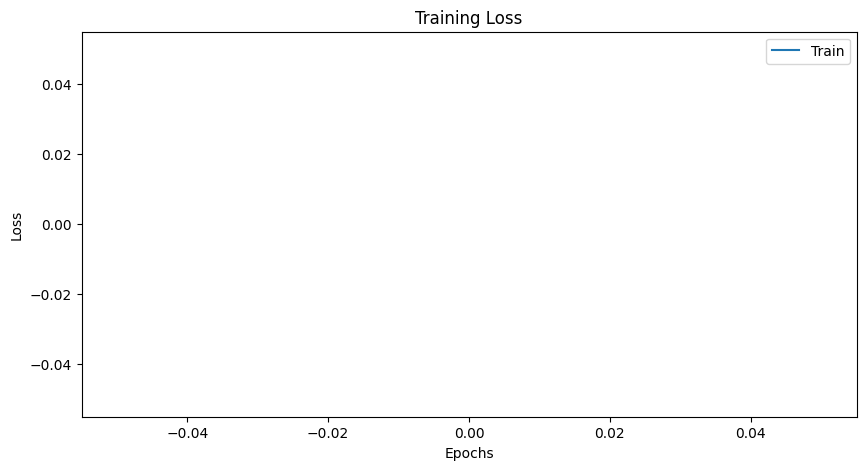

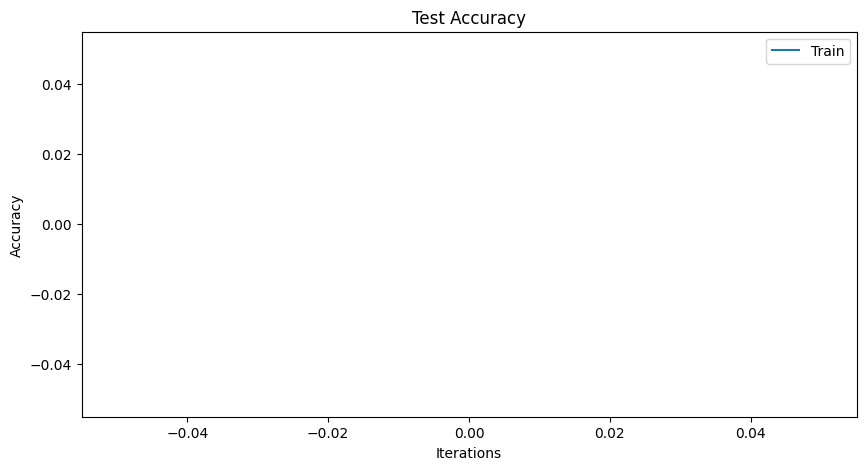

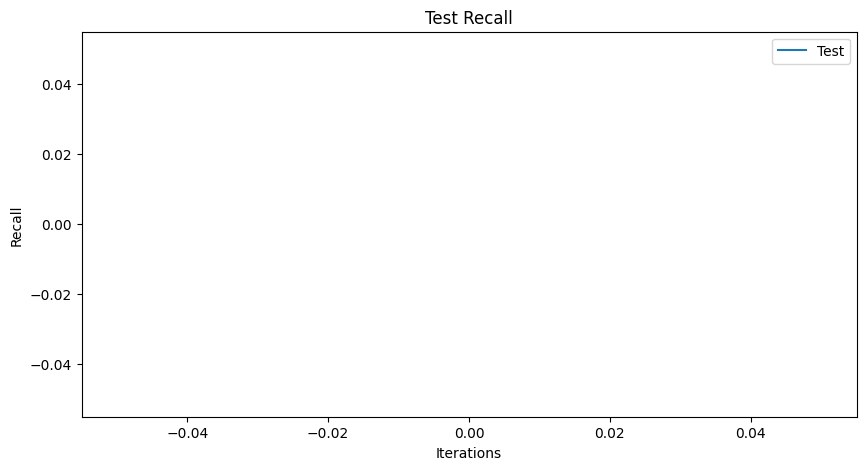

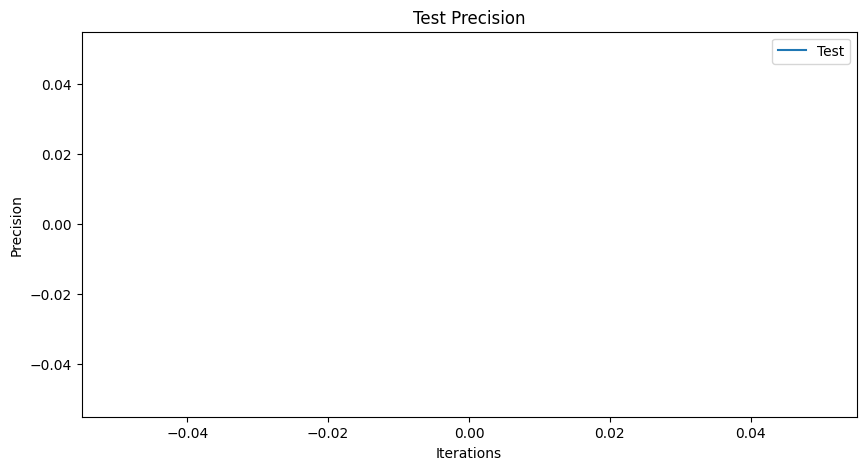

In [ ]:
#обычное обучение для берта


def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):

    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            data_slice = data.iloc[indices[start : start + batch_size]]
            yield batch, data_slice

        if not cycle: break

def train_model(model, criterion, train, test, num_epochs = 10, batch_size = 64, size_of_test = 0.2):



    training_loss_logger = []
    training_acc_logger = []
    training_recall_logger = []
    test_loss_logger = []
    test_acc_logger = []
    test_recall_logger = []
    test_precision_logger = []




    for epoch in range(num_epochs):

        train_acc = 0
        test_acc = 0
        steps = 0
        TP = 0
        FN = 0
        recall = 0

        model.train()
        for (_, data) in (
                iterate_minibatches(train, batch_size, shuffle=True, device=device)
            ):


            bs = batch["result"].size(0)
            pred = model(list(data.emails.values))
            loss = criterion(pred, batch["result"])
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=0.01)
            optimizer.step()

            training_loss_logger.append(loss.item())

            train_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
            steps += bs

            TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
            FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()


        train_acc = (train_acc/steps)
        training_acc_logger.append(train_acc)

        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        training_recall_logger.append(recall)

        model.eval()
        steps = 0
        test_acc = 0
        TP = 0
        FN = 0
        FP = 0
        recall = 0
        precision = 0


        with torch.no_grad():
            for (_, data) in (iterate_minibatches(test, batch_size=100, shuffle= False, device=device)):

                bs = len(data)
                pred = model(list(data.emails.values))
                test_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
                steps += bs
                TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()
                FP += ((torch.max(pred, 1)[1]  == 1) & (batch["result"] == 0)).sum().item()


        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        test_recall_logger.append(recall)
        test_precision_logger.append(precision)
        test_acc_logger.append(test_acc/steps)




plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_epochs*num_iterations , len(training_loss_logger)), training_loss_logger)
plt.legend(["Train"])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_epochs, len(test_acc_logger)), test_acc_logger)
plt.legend(["Train"])
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")



plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_epochs, len(test_recall_logger)), test_recall_logger)
plt.legend(["Test"])
plt.title("Test Recall")
plt.xlabel("Iterations")
plt.ylabel("Recall")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_epochs, len(test_precision_logger)), test_precision_logger)
plt.legend(["Test"])
plt.title("Test Precision")
plt.xlabel("Iterations")
plt.ylabel("Precision")

print(test_acc_logger[-10:])
print(sum(test_acc_logger[-30:]) / 30)
print(test_recall_logger[-10:])
print(sum(test_recall_logger[-30:]) / 30)
print(test_precision_logger[-10:])
print(sum(test_precision_logger[-30:]) / 30)

In [ ]:
a = [2,3,4,5]
a[-2:]

[4, 5]

In [ ]:
#активное обучение + дистиляция знаний
weights_path = '/content/drive/MyDrive/basic_conv_model.pt'
model = Conv1DClassifier(embedding_matrix, 300).to(device)
model.load_state_dict(torch.load(weights_path))


def calculate_entopy_with_threshold(model_output, num_of_iteration, k=1):

    if num_of_iteration >= 120:
      indexes = np.arange(len(model_output))
      indexes = np.random.permutation(indexes)
      return indexes[:k]

    model_output = torch.softmax(model_output, dim = -1)
    final_out = -model_output*torch.log(model_output)
    final_out = final_out.sum(dim=1)
    indices = torch.topk(final_out,k)[1]
    return indices.cpu().numpy()


def func_with_grad(logits):

    probs = torch.softmax(logits, dim = -1)

    target_1 = torch.tensor([0], dtype=torch.long, device=device)
    target_2 = torch.tensor([1], dtype=torch.long, device=device)

    loss_1 = F.cross_entropy(logits.unsqueeze(0), target_1)
    loss_2 = F.cross_entropy(logits.unsqueeze(0), target_2)

    grad_1, = torch.autograd.grad(loss_1, logits)
    grad_2, = torch.autograd.grad(loss_2, logits)

    norm_of_grad1 = torch.norm(grad_1, p=2)
    norm_of_grad2 = torch.norm(grad_2, p=2)

    norms_of_grads = torch.stack((norm_of_grad1, norm_of_grad2))

    result = (probs*norms_of_grads).sum()

    return result



def most_uncertain_with_grad(model_output, k = 1 ):
    answer = torch.stack([func_with_grad(logit)  for logit in model_output])
    return torch.topk(answer,k)[1]


def calculate_uncertanity_1(model_output, k = 1):

    model_output = torch.softmax(model_output, dim = -1)
    tensor = torch.sort(model_output, dim = - 1, descending= True)[0]
    result = torch.vmap(lambda arr: arr[0] - arr[1])(tensor)
    indices = torch.topk(-result,k)[1]
    return indices

def calculate_uncertanity_2(model_output, k = 1):

    model_output = torch.softmax(model_output, dim = -1)
    model_output = torch.max(model_output, dim = -1)[0]
    result = 1 - model_output
    indices = torch.topk(result,k)[1]
    return indices



def fill_dictionary(dict, new_data, len_of_labeled_data, offset):

      indexes = np.arange(len_of_labeled_data, len_of_labeled_data+offset)
      probs = gen_response_with_probs_batch(model_llm, new_data.emails)
      for index, prob in zip(indexes, probs):
        dict[int(index)] = prob

def extraction_probs_from_llm(model, data):

    dictionary = {}
    with torch.no_grad():
      probs = gen_response_with_probs_batch(model, data.emails.values)
      for prob, index in zip(probs, data.index):
        dictionary[index] = prob

    return dictionary



model2 = Conv1DClassifier(embedding_matrix, 300).to(device)
model2.load_state_dict(model.state_dict())
unlabeled_data, test = (file_edited_with_answers_from_llm, test_dataset)
labeled_data = file_labeled[:150]

def active_learning_distil_knowledge(model, unlabeled_data_, labeled_data_, test, num_iterations = 50, num_epochs = 5,  batch_size = 64,  num_of_samples = 45, train_acc = 0,  T = 2.0,  ce_loss_weight = 0.25, soft_target_loss_weight = 0.75):

      weights = torch.tensor([1.0, 4.0], device=device)
      criterion = nn.CrossEntropyLoss(weight=weights)
      optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
      unlabeled_data = unlabeled_data_.copy()
      labeled_data = labeled_data_.copy()

      training_loss_logger = []
      test_acc_logger = []
      test_recall_logger = []
      test_precision_logger = []

      dicitonary_with_logits_from_llm = {}
      #fill_dictionary(dicitonary_with_logits_from_llm, labeled_data, 0, 150)
      for iteration in range(num_iterations):

          batch_unlabeled = make_batch(unlabeled_data)
          model_outputs = model(batch_unlabeled["text"])
          indexes_of_uncertain_objects = calculate_entopy_with_threshold(model_outputs, iteration, num_of_samples)
          most_uncertain_objects = unlabeled_data.iloc[indexes_of_uncertain_objects].reset_index(drop=True)

          unlabeled_data = unlabeled_data.drop(indexes_of_uncertain_objects)
          unlabeled_data = unlabeled_data.reset_index(drop=True)

          #fill_dictionary(dicitonary_with_logits_from_llm, most_uncertain_objects, len(labeled_data), num_of_samples)
          labeled_data = pd.concat([labeled_data, most_uncertain_objects], ignore_index=True)



          if(iteration >= 15):

             dicitonary_with_logits_from_llm = extraction_probs_from_llm(model_llm, most_uncertain_objects)


             for epoch in range(num_epochs):
                  model.train()
                  for batch, data_slice in (iterate_minibatches(most_uncertain_objects, batch_size, shuffle= True, device=device)):


                      bs = batch["result"].size(0)
                      student_logits = model(batch["text"])

                      teacher_logits = [dicitonary_with_logits_from_llm[idx].tolist() for idx in data_slice.index]

                      teacher_logits = torch.tensor(teacher_logits)


                      optimizer.zero_grad()
                      soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1).to(device)
                      soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1).to(device)

                      soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)


                      label_loss = criterion(student_logits, batch["result"])


                      loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

                      loss.backward()
                      optimizer.step()

          else:

                for epoch in range(num_epochs):
                  model.train()
                  for batch, _ in (iterate_minibatches(labeled_data, batch_size, shuffle= True, device=device)):
                      bs = batch["result"].size(0)
                      pred = model(batch["text"])
                      loss = criterion(pred, batch["result"])
                      optimizer.zero_grad()
                      loss.backward()
                      nn.utils.clip_grad_value_(model.parameters(), clip_value=0.01)
                      optimizer.step()
                      training_loss_logger.append(loss.item())

          steps = 0
          test_acc = 0
          TP = 0
          FN = 0
          FP = 0
          recall = 0
          precision = 0

          model.eval()
          for batch, _ in (iterate_minibatches(test, batch_size=100, shuffle= False, device=device)):

                      bs = batch["result"].size(0)
                      pred = model(batch["text"])
                      test_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
                      steps += bs
                      TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                      FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()
                      FP += ((torch.max(pred, 1)[1]  == 1) & (batch["result"] == 0)).sum().item()


          recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
          precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
          test_recall_logger.append(recall)
          test_precision_logger.append(precision)
          test_acc_logger.append(test_acc/steps)




      plt.figure(figsize=(10, 5))
      plt.plot(np.linspace(0, num_epochs*num_iterations , len(training_loss_logger)), training_loss_logger)
      plt.legend(["Train"])
      plt.title("Training Loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")


      plt.figure(figsize=(10, 5))
      plt.plot(np.linspace(0, num_iterations, len(test_acc_logger)), test_acc_logger)
      plt.legend(["Train"])
      plt.title("Test Accuracy")
      plt.xlabel("Iterations")
      plt.ylabel("Accuracy")



      plt.figure(figsize=(10, 5))
      plt.plot(np.linspace(0, num_iterations, len(test_recall_logger)), test_recall_logger)
      plt.legend(["Test"])
      plt.title("Test Recall")
      plt.xlabel("Iterations")
      plt.ylabel("Recall")


      plt.figure(figsize=(10, 5))
      plt.plot(np.linspace(0, num_iterations, len(test_precision_logger)), test_precision_logger)
      plt.legend(["Test"])
      plt.title("Test Precision")
      plt.xlabel("Iterations")
      plt.ylabel("Precision")

      print(test_acc_logger[-10:])
      print(sum(test_acc_logger[-30:]) / 30)
      print(test_recall_logger[-10:])
      print(sum(test_recall_logger[-30:]) / 30)
      print(test_precision_logger[-10:])
      print(sum(test_precision_logger[-30:]) / 30)


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04464222431182861
Epoch 2/5, Loss: 0.08853578567504883
Epoch 3/5, Loss: 0.13171218872070312
Epoch 4/5, Loss: 0.1742151641845703
Epoch 5/5, Loss: 0.2160871696472168


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04499680042266846
Epoch 2/5, Loss: 0.08945809841156006
Epoch 3/5, Loss: 0.13333600997924805
Epoch 4/5, Loss: 0.17663397312164306
Epoch 5/5, Loss: 0.21935858249664306


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.043757238388061524
Epoch 2/5, Loss: 0.08708921432495118
Epoch 3/5, Loss: 0.1299506950378418
Epoch 4/5, Loss: 0.17231313705444337
Epoch 5/5, Loss: 0.21415992736816405


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.049008145332336425
Epoch 2/5, Loss: 0.09808665752410889
Epoch 3/5, Loss: 0.14718394756317138
Epoch 4/5, Loss: 0.1962565326690674
Epoch 5/5, Loss: 0.24526868820190428


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03652713298797607
Epoch 2/5, Loss: 0.07293871879577636
Epoch 3/5, Loss: 0.10918290615081787
Epoch 4/5, Loss: 0.14521634578704834
Epoch 5/5, Loss: 0.18100377321243286


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.042403888702392575
Epoch 2/5, Loss: 0.08474575996398925
Epoch 3/5, Loss: 0.12698046684265138
Epoch 4/5, Loss: 0.16906918048858643
Epoch 5/5, Loss: 0.21098042011260987


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0370761251449585
Epoch 2/5, Loss: 0.0740076732635498
Epoch 3/5, Loss: 0.11074915409088135
Epoch 4/5, Loss: 0.14726497173309328
Epoch 5/5, Loss: 0.18352767944335938


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.050098142623901366
Epoch 2/5, Loss: 0.10024587631225586
Epoch 3/5, Loss: 0.15036502361297607
Epoch 4/5, Loss: 0.20038977146148682
Epoch 5/5, Loss: 0.2502613115310669


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.033300037384033206
Epoch 2/5, Loss: 0.06655959367752075
Epoch 3/5, Loss: 0.09972774744033813
Epoch 4/5, Loss: 0.1327616333961487
Epoch 5/5, Loss: 0.16562448263168336


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04521847248077392
Epoch 2/5, Loss: 0.09035283088684082
Epoch 3/5, Loss: 0.1353464889526367
Epoch 4/5, Loss: 0.1801561689376831
Epoch 5/5, Loss: 0.22474429607391358


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.053894486427307126
Epoch 2/5, Loss: 0.10775891780853271
Epoch 3/5, Loss: 0.16152571201324462
Epoch 4/5, Loss: 0.21513789176940917
Epoch 5/5, Loss: 0.26854700565338135


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04140548706054688
Epoch 2/5, Loss: 0.0827732515335083
Epoch 3/5, Loss: 0.12404873847961426
Epoch 4/5, Loss: 0.1651856517791748
Epoch 5/5, Loss: 0.2061455726623535


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.06393229484558105
Epoch 2/5, Loss: 0.12772239685058595
Epoch 3/5, Loss: 0.19124253273010253
Epoch 4/5, Loss: 0.2543882656097412
Epoch 5/5, Loss: 0.3170729064941406


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03630184650421143
Epoch 2/5, Loss: 0.07266937017440796
Epoch 3/5, Loss: 0.10901735067367553
Epoch 4/5, Loss: 0.14527347326278686
Epoch 5/5, Loss: 0.1813778281211853


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05641347408294678
Epoch 2/5, Loss: 0.11270251750946045
Epoch 3/5, Loss: 0.1687729024887085
Epoch 4/5, Loss: 0.22454647541046144
Epoch 5/5, Loss: 0.2799605178833008


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04241471290588379
Epoch 2/5, Loss: 0.08479214668273925
Epoch 3/5, Loss: 0.12709881305694581
Epoch 4/5, Loss: 0.16930538177490234
Epoch 5/5, Loss: 0.21138759613037109


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04365500926971436
Epoch 2/5, Loss: 0.08724715232849121
Epoch 3/5, Loss: 0.13073403358459473
Epoch 4/5, Loss: 0.17407883167266847
Epoch 5/5, Loss: 0.21725136756896973


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05529718399047852
Epoch 2/5, Loss: 0.11045679092407226
Epoch 3/5, Loss: 0.16542215824127196
Epoch 4/5, Loss: 0.22014493465423585
Epoch 5/5, Loss: 0.2745846748352051


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.036874094009399415
Epoch 2/5, Loss: 0.0737952446937561
Epoch 3/5, Loss: 0.11064136266708374
Epoch 4/5, Loss: 0.14731164932250976
Epoch 5/5, Loss: 0.18371819257736205


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04471403121948242
Epoch 2/5, Loss: 0.08936940670013428
Epoch 3/5, Loss: 0.13392013549804688
Epoch 4/5, Loss: 0.17832733154296876
Epoch 5/5, Loss: 0.2225613498687744


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03567986726760864
Epoch 2/5, Loss: 0.07120054721832275
Epoch 3/5, Loss: 0.10648277759552002
Epoch 4/5, Loss: 0.14146059036254882
Epoch 5/5, Loss: 0.17608209133148192


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03707914590835571
Epoch 2/5, Loss: 0.07389183998107911
Epoch 3/5, Loss: 0.11038228034973145
Epoch 4/5, Loss: 0.14650481939315796
Epoch 5/5, Loss: 0.18222365856170655


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04594888687133789
Epoch 2/5, Loss: 0.09188764095306397
Epoch 3/5, Loss: 0.13775845050811766
Epoch 4/5, Loss: 0.18351393222808837
Epoch 5/5, Loss: 0.2291122007369995


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.032384023666381836
Epoch 2/5, Loss: 0.06460925579071045
Epoch 3/5, Loss: 0.09662714958190918
Epoch 4/5, Loss: 0.1283974266052246
Epoch 5/5, Loss: 0.15988691091537477


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05129339694976807
Epoch 2/5, Loss: 0.10264956951141357
Epoch 3/5, Loss: 0.15396470546722413
Epoch 4/5, Loss: 0.20514995574951173
Epoch 5/5, Loss: 0.25612722396850585


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.047516555786132814
Epoch 2/5, Loss: 0.09492501258850097
Epoch 3/5, Loss: 0.14217885971069336
Epoch 4/5, Loss: 0.18923694133758545
Epoch 5/5, Loss: 0.23606665134429933


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04962191581726074
Epoch 2/5, Loss: 0.09904859542846679
Epoch 3/5, Loss: 0.1482278060913086
Epoch 4/5, Loss: 0.19711874008178712
Epoch 5/5, Loss: 0.2456871747970581


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.041529884338378904
Epoch 2/5, Loss: 0.08286187171936035
Epoch 3/5, Loss: 0.12395905494689942
Epoch 4/5, Loss: 0.16479896545410155
Epoch 5/5, Loss: 0.20536528587341307


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.039606316089630125
Epoch 2/5, Loss: 0.07920672655105591
Epoch 3/5, Loss: 0.11877649545669555
Epoch 4/5, Loss: 0.1582958197593689
Epoch 5/5, Loss: 0.197746319770813


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04501278877258301
Epoch 2/5, Loss: 0.08991827011108398
Epoch 3/5, Loss: 0.13464765071868898
Epoch 4/5, Loss: 0.1791474390029907
Epoch 5/5, Loss: 0.22337210655212403


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04261932373046875
Epoch 2/5, Loss: 0.0851826000213623
Epoch 3/5, Loss: 0.1276458740234375
Epoch 4/5, Loss: 0.16997040748596193
Epoch 5/5, Loss: 0.21212377548217773


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03402846336364746
Epoch 2/5, Loss: 0.06793526411056519
Epoch 3/5, Loss: 0.10165457010269165
Epoch 4/5, Loss: 0.1351318621635437
Epoch 5/5, Loss: 0.16832055807113647


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04397900104522705
Epoch 2/5, Loss: 0.08788837432861328
Epoch 3/5, Loss: 0.1316999626159668
Epoch 4/5, Loss: 0.1753891611099243
Epoch 5/5, Loss: 0.2189352798461914


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.060473122596740723
Epoch 2/5, Loss: 0.12095444679260253
Epoch 3/5, Loss: 0.1812887954711914
Epoch 4/5, Loss: 0.2413451099395752
Epoch 5/5, Loss: 0.3010124778747559


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.046608991622924804
Epoch 2/5, Loss: 0.09313724517822265
Epoch 3/5, Loss: 0.13953682899475098
Epoch 4/5, Loss: 0.18576894760131835
Epoch 5/5, Loss: 0.23179944038391112


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.043273000717163085
Epoch 2/5, Loss: 0.08647375106811524
Epoch 3/5, Loss: 0.1295578098297119
Epoch 4/5, Loss: 0.17248755931854248
Epoch 5/5, Loss: 0.21523324012756348


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05346913337707519
Epoch 2/5, Loss: 0.10677416801452637
Epoch 3/5, Loss: 0.15985403060913086
Epoch 4/5, Loss: 0.2126580810546875
Epoch 5/5, Loss: 0.26514593601226805


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04606985092163086
Epoch 2/5, Loss: 0.09203139305114746
Epoch 3/5, Loss: 0.13784700393676758
Epoch 4/5, Loss: 0.18348764419555663
Epoch 5/5, Loss: 0.22893231391906738


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04249578475952148
Epoch 2/5, Loss: 0.08496567726135254
Epoch 3/5, Loss: 0.12735133171081542
Epoch 4/5, Loss: 0.16960283279418945
Epoch 5/5, Loss: 0.21167834281921385


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.038913908004760744
Epoch 2/5, Loss: 0.07776281833648682
Epoch 3/5, Loss: 0.11647334814071655
Epoch 4/5, Loss: 0.15498295545578003
Epoch 5/5, Loss: 0.19323989152908325


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04725990772247315
Epoch 2/5, Loss: 0.09446340084075927
Epoch 3/5, Loss: 0.14156846523284913
Epoch 4/5, Loss: 0.18853888988494874
Epoch 5/5, Loss: 0.2353421449661255


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.047899932861328126
Epoch 2/5, Loss: 0.09577796936035156
Epoch 3/5, Loss: 0.1435794734954834
Epoch 4/5, Loss: 0.191265811920166
Epoch 5/5, Loss: 0.23879873275756835


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.037089531421661374
Epoch 2/5, Loss: 0.07413591146469116
Epoch 3/5, Loss: 0.11109601497650147
Epoch 4/5, Loss: 0.1479323673248291
Epoch 5/5, Loss: 0.1846126890182495


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05678217887878418
Epoch 2/5, Loss: 0.11352901458740235
Epoch 3/5, Loss: 0.17012561321258546
Epoch 4/5, Loss: 0.22647107601165772
Epoch 5/5, Loss: 0.28248071670532227


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.038018462657928465
Epoch 2/5, Loss: 0.0760465407371521
Epoch 3/5, Loss: 0.11399023771286011
Epoch 4/5, Loss: 0.15176701307296753
Epoch 5/5, Loss: 0.18930554628372193


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04174933433532715
Epoch 2/5, Loss: 0.08334171772003174
Epoch 3/5, Loss: 0.12470863342285156
Epoch 4/5, Loss: 0.16579407215118408
Epoch 5/5, Loss: 0.20654809474945068


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.040366015434265136
Epoch 2/5, Loss: 0.08062013149261475
Epoch 3/5, Loss: 0.12073437690734863
Epoch 4/5, Loss: 0.1606855010986328
Epoch 5/5, Loss: 0.20045490026474


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03889384031295776
Epoch 2/5, Loss: 0.0777039122581482
Epoch 3/5, Loss: 0.11640067338943481
Epoch 4/5, Loss: 0.15496155500411987
Epoch 5/5, Loss: 0.1933678412437439


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04047759056091309
Epoch 2/5, Loss: 0.08092188835144043
Epoch 3/5, Loss: 0.12129745483398438
Epoch 4/5, Loss: 0.16157408714294433
Epoch 5/5, Loss: 0.2017279291152954


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0360357928276062
Epoch 2/5, Loss: 0.07196735143661499
Epoch 3/5, Loss: 0.10775193214416504
Epoch 4/5, Loss: 0.14335537433624268
Epoch 5/5, Loss: 0.17874760866165162


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04220600128173828
Epoch 2/5, Loss: 0.08438785552978516
Epoch 3/5, Loss: 0.12649616718292236
Epoch 4/5, Loss: 0.1684886932373047
Epoch 5/5, Loss: 0.21033554553985595


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.054927310943603515
Epoch 2/5, Loss: 0.10979633331298828
Epoch 3/5, Loss: 0.16452492713928224
Epoch 4/5, Loss: 0.2190423107147217
Epoch 5/5, Loss: 0.27328986167907715


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.06322749614715577
Epoch 2/5, Loss: 0.1260274362564087
Epoch 3/5, Loss: 0.1882958459854126
Epoch 4/5, Loss: 0.2499346590042114
Epoch 5/5, Loss: 0.31086674213409426


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.044996452331542966
Epoch 2/5, Loss: 0.08994821548461913
Epoch 3/5, Loss: 0.1348003101348877
Epoch 4/5, Loss: 0.17950779914855958
Epoch 5/5, Loss: 0.22403205871582033


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.049827194213867186
Epoch 2/5, Loss: 0.09954227924346924
Epoch 3/5, Loss: 0.14909559726715088
Epoch 4/5, Loss: 0.19844472408294678
Epoch 5/5, Loss: 0.24755465507507324


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04643908500671387
Epoch 2/5, Loss: 0.09271752834320068
Epoch 3/5, Loss: 0.13879129886627198
Epoch 4/5, Loss: 0.18462779998779297
Epoch 5/5, Loss: 0.2302018642425537


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.040197434425354006
Epoch 2/5, Loss: 0.08038548946380615
Epoch 3/5, Loss: 0.12052449703216553
Epoch 4/5, Loss: 0.16057921886444093
Epoch 5/5, Loss: 0.20052037239074708


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.037682480812072754
Epoch 2/5, Loss: 0.07533403396606446
Epoch 3/5, Loss: 0.11291381359100341
Epoch 4/5, Loss: 0.1503860855102539
Epoch 5/5, Loss: 0.18772170066833496


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.050609984397888184
Epoch 2/5, Loss: 0.10121056079864502
Epoch 3/5, Loss: 0.15175844192504884
Epoch 4/5, Loss: 0.20221611976623535
Epoch 5/5, Loss: 0.2525534200668335


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.036242198944091794
Epoch 2/5, Loss: 0.07242748260498047
Epoch 3/5, Loss: 0.10844380378723145
Epoch 4/5, Loss: 0.1441924023628235
Epoch 5/5, Loss: 0.1795899248123169


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.038025426864624026
Epoch 2/5, Loss: 0.0757831859588623
Epoch 3/5, Loss: 0.11321627378463744
Epoch 4/5, Loss: 0.15027852296829225
Epoch 5/5, Loss: 0.18693259000778198


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04344555377960205
Epoch 2/5, Loss: 0.08672614574432373
Epoch 3/5, Loss: 0.129804048538208
Epoch 4/5, Loss: 0.17264935493469238
Epoch 5/5, Loss: 0.21523970127105713


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.037669649124145506
Epoch 2/5, Loss: 0.07509232521057128
Epoch 3/5, Loss: 0.11222536325454711
Epoch 4/5, Loss: 0.1490363907814026
Epoch 5/5, Loss: 0.18549740076065063


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.060923380851745604
Epoch 2/5, Loss: 0.12200300216674805
Epoch 3/5, Loss: 0.18307297706604003
Epoch 4/5, Loss: 0.24398780822753907
Epoch 5/5, Loss: 0.3046251249313354


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.02757380485534668
Epoch 2/5, Loss: 0.055159378051757815
Epoch 3/5, Loss: 0.08268401145935059
Epoch 4/5, Loss: 0.11008431434631348
Epoch 5/5, Loss: 0.13730579376220703


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.050528674125671386
Epoch 2/5, Loss: 0.10106279850006103
Epoch 3/5, Loss: 0.1515483093261719
Epoch 4/5, Loss: 0.20193765163421631
Epoch 5/5, Loss: 0.2521899938583374


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.042826762199401854
Epoch 2/5, Loss: 0.08562139511108398
Epoch 3/5, Loss: 0.1283576011657715
Epoch 4/5, Loss: 0.1710139513015747
Epoch 5/5, Loss: 0.21357272148132325


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04520276546478272
Epoch 2/5, Loss: 0.09034871578216552
Epoch 3/5, Loss: 0.13539474964141845
Epoch 4/5, Loss: 0.180304856300354
Epoch 5/5, Loss: 0.22504785060882568


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03943328857421875
Epoch 2/5, Loss: 0.078818678855896
Epoch 3/5, Loss: 0.11811156511306763
Epoch 4/5, Loss: 0.15727450847625732
Epoch 5/5, Loss: 0.19627450466156005


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04674274444580078
Epoch 2/5, Loss: 0.09339293479919433
Epoch 3/5, Loss: 0.1398829126358032
Epoch 4/5, Loss: 0.1861560869216919
Epoch 5/5, Loss: 0.23216631889343262


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.06294756412506103
Epoch 2/5, Loss: 0.12559278964996337
Epoch 3/5, Loss: 0.18774984836578368
Epoch 4/5, Loss: 0.2492663860321045
Epoch 5/5, Loss: 0.31001843452453615


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.032725636959075925
Epoch 2/5, Loss: 0.06565780401229858
Epoch 3/5, Loss: 0.09870718240737915
Epoch 4/5, Loss: 0.13179127454757691
Epoch 5/5, Loss: 0.16483324527740478


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.033800544738769533
Epoch 2/5, Loss: 0.06757348537445068
Epoch 3/5, Loss: 0.10123824834823608
Epoch 4/5, Loss: 0.1347238278388977
Epoch 5/5, Loss: 0.1679702115058899


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04148290634155274
Epoch 2/5, Loss: 0.0828852891921997
Epoch 3/5, Loss: 0.12417081356048584
Epoch 4/5, Loss: 0.16530806064605713
Epoch 5/5, Loss: 0.206271653175354


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03979252815246582
Epoch 2/5, Loss: 0.07954144477844238
Epoch 3/5, Loss: 0.1192082405090332
Epoch 4/5, Loss: 0.15876118183135987
Epoch 5/5, Loss: 0.19817251682281495


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04423942565917969
Epoch 2/5, Loss: 0.08843467712402343
Epoch 3/5, Loss: 0.13254864692687987
Epoch 4/5, Loss: 0.17655210494995116
Epoch 5/5, Loss: 0.2204191780090332


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05072520256042481
Epoch 2/5, Loss: 0.10140934944152832
Epoch 3/5, Loss: 0.1519757652282715
Epoch 4/5, Loss: 0.2023569440841675
Epoch 5/5, Loss: 0.25249377250671384


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0385386848449707
Epoch 2/5, Loss: 0.07702884674072266
Epoch 3/5, Loss: 0.11540168046951294
Epoch 4/5, Loss: 0.15359789609909058
Epoch 5/5, Loss: 0.1915699362754822


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.040054311752319334
Epoch 2/5, Loss: 0.08004038572311402
Epoch 3/5, Loss: 0.11991308212280273
Epoch 4/5, Loss: 0.159634747505188
Epoch 5/5, Loss: 0.19917309284210205


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05364808082580566
Epoch 2/5, Loss: 0.10725817680358887
Epoch 3/5, Loss: 0.16077861785888672
Epoch 4/5, Loss: 0.21416494369506836
Epoch 5/5, Loss: 0.2673781442642212


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.030192532539367677
Epoch 2/5, Loss: 0.060344691276550295
Epoch 3/5, Loss: 0.09039648532867432
Epoch 4/5, Loss: 0.12029549837112427
Epoch 5/5, Loss: 0.14999742269515992


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.044684858322143556
Epoch 2/5, Loss: 0.08939291954040528
Epoch 3/5, Loss: 0.13406471252441407
Epoch 4/5, Loss: 0.17864731788635255
Epoch 5/5, Loss: 0.2230961275100708


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04451183795928955
Epoch 2/5, Loss: 0.08899219989776612
Epoch 3/5, Loss: 0.13340850353240966
Epoch 4/5, Loss: 0.1777337074279785
Epoch 5/5, Loss: 0.22194455146789552


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0372014856338501
Epoch 2/5, Loss: 0.0743719482421875
Epoch 3/5, Loss: 0.111457839012146
Epoch 4/5, Loss: 0.1484132194519043
Epoch 5/5, Loss: 0.185199511051178


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04741955280303955
Epoch 2/5, Loss: 0.0947762155532837
Epoch 3/5, Loss: 0.14201509952545166
Epoch 4/5, Loss: 0.18908939838409425
Epoch 5/5, Loss: 0.2359609842300415


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.064923095703125
Epoch 2/5, Loss: 0.12958932876586915
Epoch 3/5, Loss: 0.19385580062866212
Epoch 4/5, Loss: 0.2575938558578491
Epoch 5/5, Loss: 0.32070374965667725


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03654992818832398
Epoch 2/5, Loss: 0.07321926355361938
Epoch 3/5, Loss: 0.10992443561553955
Epoch 4/5, Loss: 0.14659152746200563
Epoch 5/5, Loss: 0.18315449476242066


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03883233070373535
Epoch 2/5, Loss: 0.07762271881103516
Epoch 3/5, Loss: 0.11631136417388915
Epoch 4/5, Loss: 0.15484799385070802
Epoch 5/5, Loss: 0.1931868600845337


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03926701307296753
Epoch 2/5, Loss: 0.0784830641746521
Epoch 3/5, Loss: 0.1175842523574829
Epoch 4/5, Loss: 0.15651417255401612
Epoch 5/5, Loss: 0.19522449016571045


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.040695595741271975
Epoch 2/5, Loss: 0.08129958629608154
Epoch 3/5, Loss: 0.12176014423370361
Epoch 4/5, Loss: 0.16203127861022948
Epoch 5/5, Loss: 0.20207505226135253


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.029284358024597168
Epoch 2/5, Loss: 0.05835784196853638
Epoch 3/5, Loss: 0.08714498281478882
Epoch 4/5, Loss: 0.11558694362640382
Epoch 5/5, Loss: 0.1436416006088257


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.05222448825836182
Epoch 2/5, Loss: 0.10451782703399658
Epoch 3/5, Loss: 0.15680468559265137
Epoch 4/5, Loss: 0.2090187120437622
Epoch 5/5, Loss: 0.2611029386520386


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03434278964996338
Epoch 2/5, Loss: 0.0685643982887268
Epoch 3/5, Loss: 0.10258915662765503
Epoch 4/5, Loss: 0.13635250329971313
Epoch 5/5, Loss: 0.16980098009109498


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.0389300799369812
Epoch 2/5, Loss: 0.07777506589889527
Epoch 3/5, Loss: 0.11650063276290894
Epoch 4/5, Loss: 0.1550765109062195
Epoch 5/5, Loss: 0.19347663164138795


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04890690326690674
Epoch 2/5, Loss: 0.09778859615325927
Epoch 3/5, Loss: 0.1465792751312256
Epoch 4/5, Loss: 0.1952243137359619
Epoch 5/5, Loss: 0.24367573738098144


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04003769874572754
Epoch 2/5, Loss: 0.08001313209533692
Epoch 3/5, Loss: 0.11987497091293335
Epoch 4/5, Loss: 0.1595789909362793
Epoch 5/5, Loss: 0.19908856153488158


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04973893165588379
Epoch 2/5, Loss: 0.0994439697265625
Epoch 3/5, Loss: 0.14903778076171875
Epoch 4/5, Loss: 0.19845338344573973
Epoch 5/5, Loss: 0.24763649463653564


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.04603549957275391
Epoch 2/5, Loss: 0.09198699474334716
Epoch 3/5, Loss: 0.13781819820404054
Epoch 4/5, Loss: 0.1834987735748291
Epoch 5/5, Loss: 0.22900319576263428


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.059712400436401365
Epoch 2/5, Loss: 0.11909367561340332
Epoch 3/5, Loss: 0.17803020000457764
Epoch 4/5, Loss: 0.2364331579208374
Epoch 5/5, Loss: 0.2942278146743774


/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5, Loss: 0.03555370807647705
Epoch 2/5, Loss: 0.07121644258499145
Epoch 3/5, Loss: 0.10689247131347657
Epoch 4/5, Loss: 0.14249759197235107
Epoch 5/5, Loss: 0.1779565191268921
[0.54, 0.5533333333333333, 0.5566666666666666, 0.56, 0.5666666666666667, 0.5666666666666667, 0.57, 0.5766666666666667, 0.58, 0.59]
0.5407777777777778
[0.09333333333333334, 0.12, 0.12666666666666668, 0.14, 0.15333333333333332, 0.15333333333333332, 0.16, 0.17333333333333334, 0.18, 0.2]
0.08800000000000001
[0.875, 0.9, 0.9047619047619048, 0.875, 0.8846153846153846, 0.8846153846153846, 0.8888888888888888, 0.896551724137931, 0.9, 0.9090909090909091]
0.9593476319338387


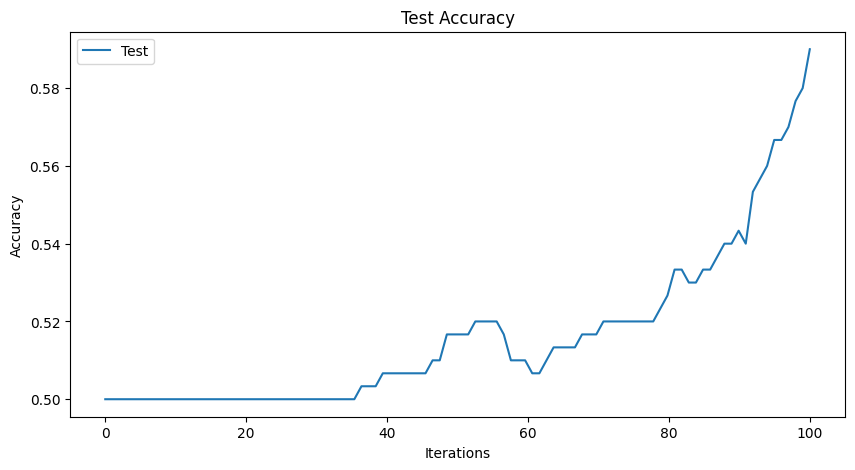

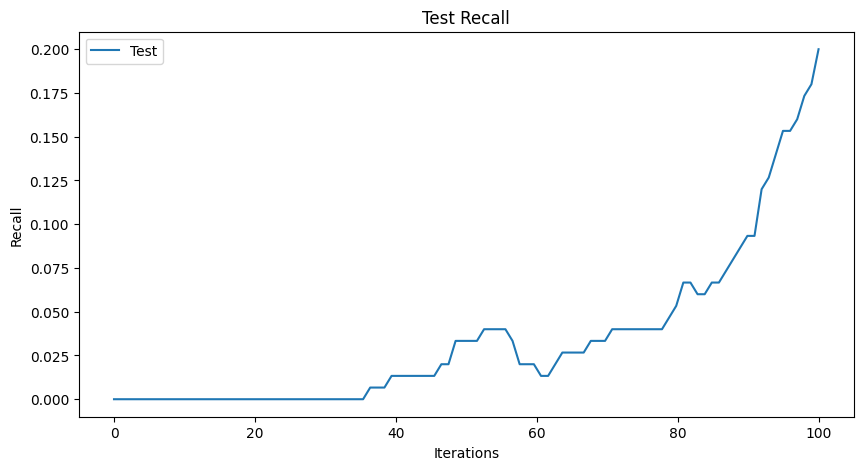

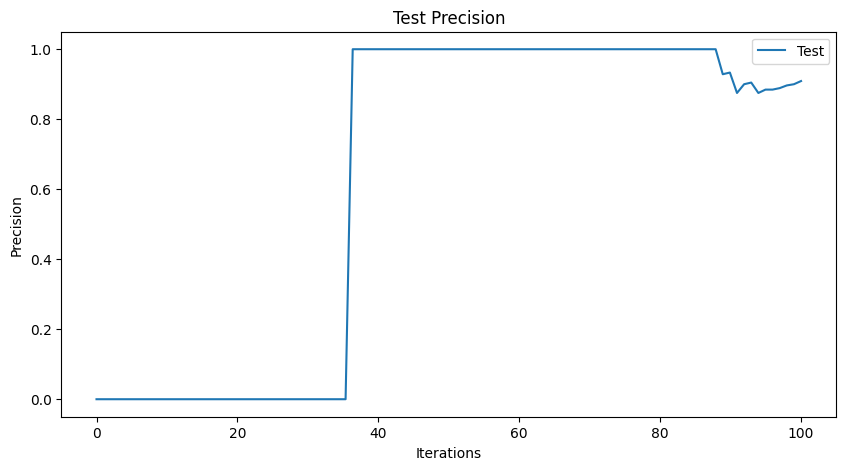

In [ ]:
weights_path = '/content/drive/MyDrive/basic_conv_model.pt'
model = Conv1DClassifier(embedding_matrix, 300).to(device)
model.load_state_dict(torch.load(weights_path))


train_knowledge_distillation_second_version(model_llm, model, 5,  T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, train_for_distil = file_edited_with_answers_from_llm, test_for_distil = test_dataset, device=device,  num_iterations = 100, num_of_samples = 25)

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 duri

[0.8766666666666667, 0.8666666666666667, 0.86, 0.8633333333333333, 0.86, 0.86, 0.8633333333333333, 0.8566666666666667, 0.86, 0.8566666666666667]
0.8339999999999999
[0.8533333333333334, 0.8533333333333334, 0.86, 0.8666666666666667, 0.8666666666666667, 0.88, 0.8933333333333333, 0.8933333333333333, 0.9, 0.9]
0.7522222222222221
[0.8951048951048951, 0.8767123287671232, 0.86, 0.8609271523178808, 0.8552631578947368, 0.8461538461538461, 0.8427672955974843, 0.8322981366459627, 0.8333333333333334, 0.8282208588957055]
0.9067981879141642


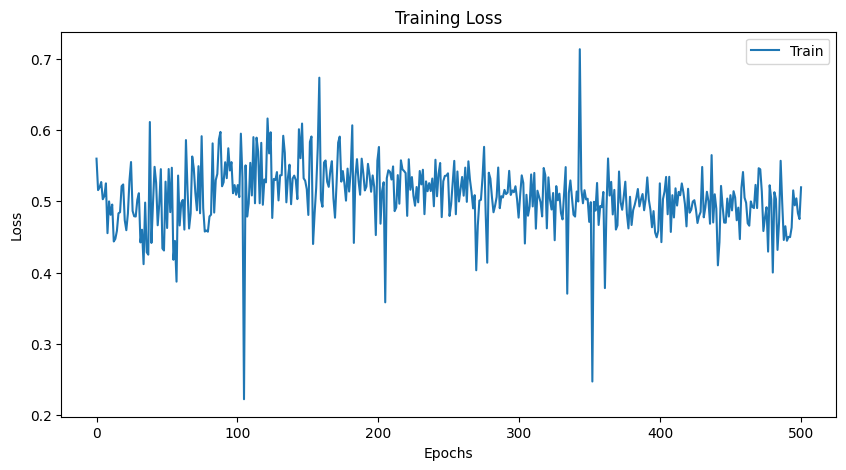

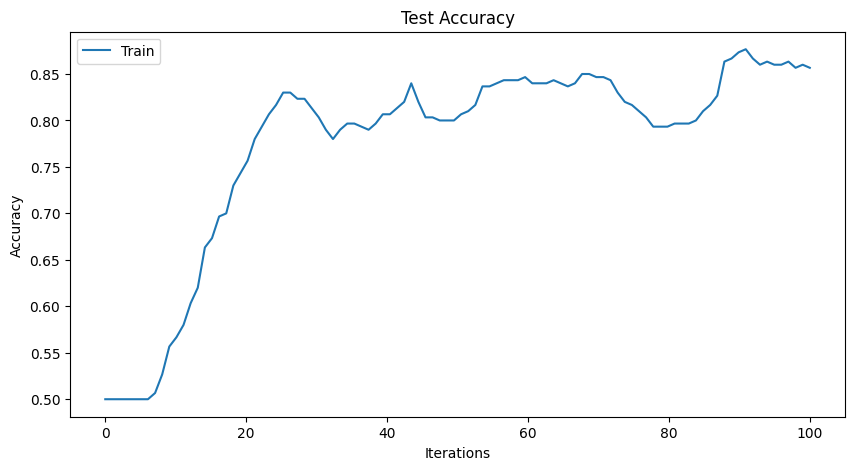

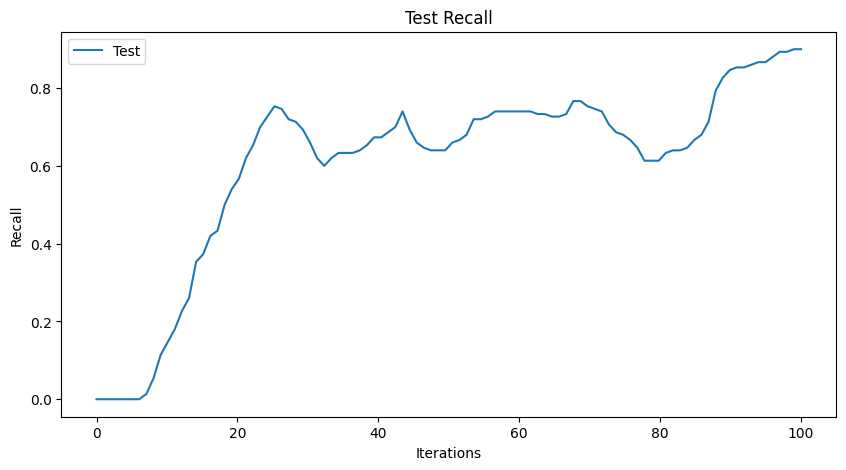

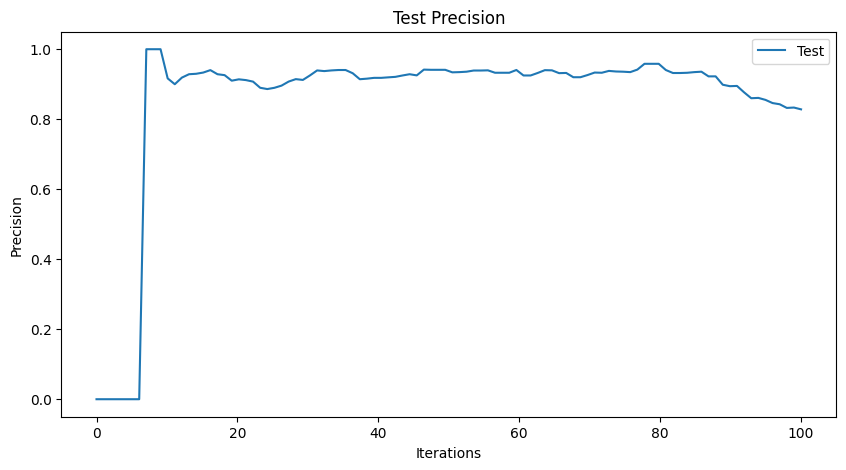

In [ ]:

weights_path = '/content/drive/MyDrive/basic_conv_model.pt'
model = Conv1DClassifier(embedding_matrix, 300).to(device)
model.load_state_dict(torch.load(weights_path))

unlabeled_data, test = (file_edited_with_answers_from_llm, test_dataset)
labeled_data = file_labeled[:150]
active_learning_distil_knowledge(model, unlabeled_data, labeled_data, test, num_iterations = 100, num_of_samples = 25, T = 2.0, ce_loss_weight = 0.75, soft_target_loss_weight = 0.25)

Выходные данные были обрезаны до нескольких последних строк (5000).
        [ 464, 1016,  463,  119,  335,  386,  360,  166,   31,  472],
        [  20, 1162,  132,   87,  725, 1053,    1,    1,    1,    1]],
       device='cuda:0'), 'result': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')}
{'text': tensor([[ 548,  277,  193,  351,  359,  439, 1214,  811,  369,    1],
        [  57,  984,  230,  857,    1,    1,    1,    1,    1,    1],
        [ 430,  386,  485,    0,    0,    1,    1,    1,    1,    1],
        [ 441,    0,  102,  423,   60,    1,    1,    1,    1,    1],
        [ 673,  820,  536,  821,  395,  119,    1,    1,    1,    1],
        [ 533,  903,  904,  905,  904,  906,  265,  227,    0,  870],
        [1101, 1170, 1171, 1172,  694,  695, 1173,    1,    1,    1],
        [ 947,    1,  

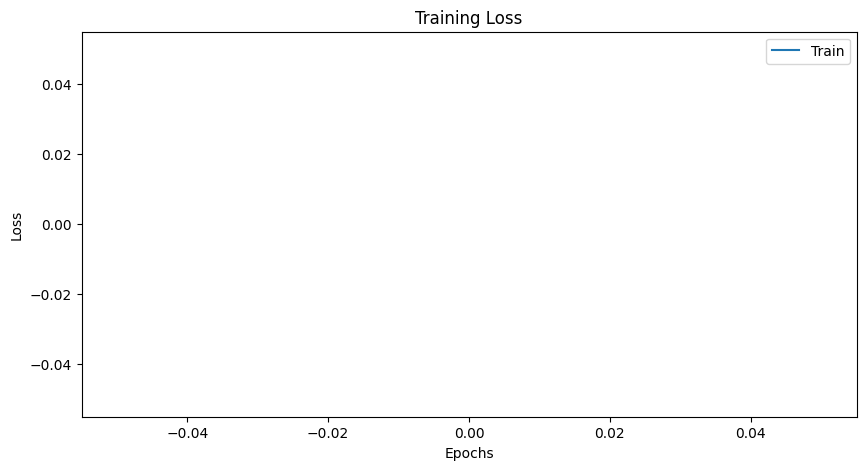

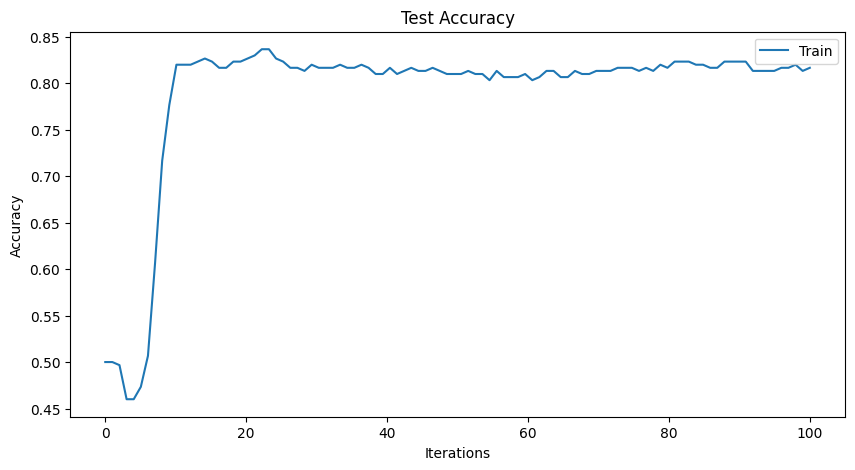

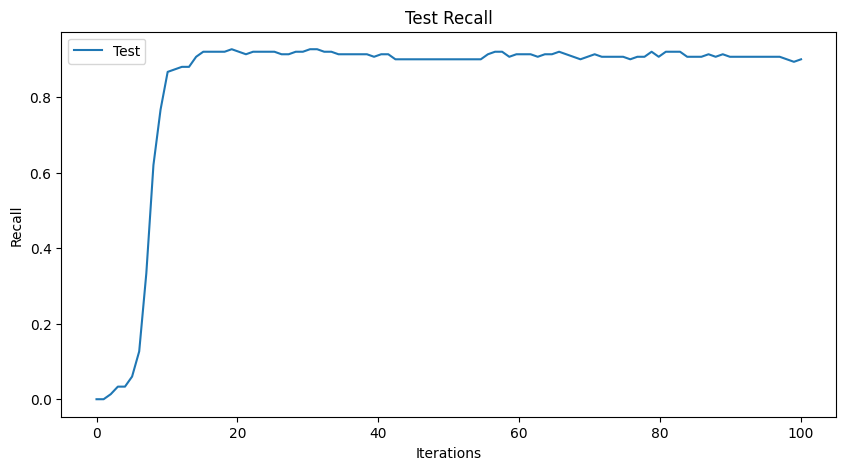

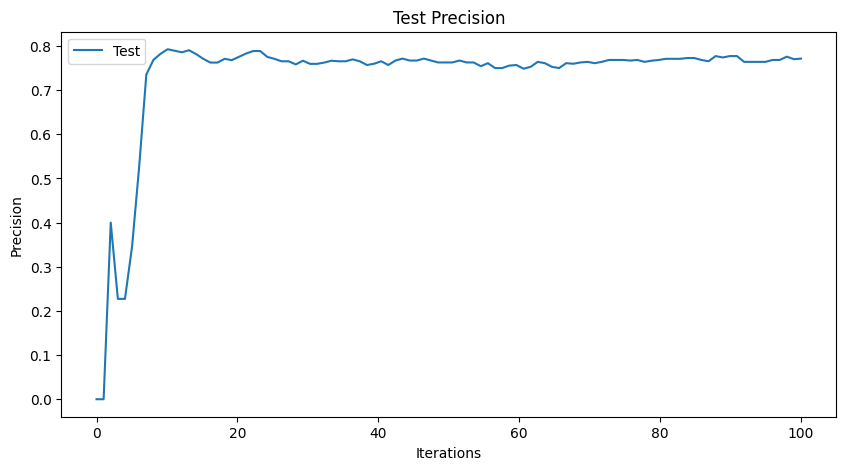

In [ ]:
ensemble = []
optimizers = []
num_networks = 5


weights_path = '/content/drive/MyDrive/basic_conv_model.pt'
model = Conv1DClassifier(embedding_matrix, 300).to(device)
model.load_state_dict(torch.load(weights_path))


for i in range(num_networks):
    new_net = Conv1DClassifier(embedding_matrix, 300).to(device)
    new_net.to(device)
    ensemble.append(new_net)
    new_optimizer = torch.optim.Adam(new_net.parameters(), lr=1e-4)
    optimizers.append(new_optimizer)


for net_id, net in enumerate(ensemble):
 optimizer = optimizers[net_id]
 for epoch in range(20):

        net.train()
        for i, (batch, _) in enumerate(
                iterate_minibatches(file_labeled[:150], 64, shuffle=True, device=device)
            ):
            print(batch)
            pred = net(batch["text"])
            loss = criterion(pred, batch["result"])
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), max_norm = 0.5)
            optimizer.step()


ensemble[0].load_state_dict(model.state_dict())

def predict_uncertainties(ensemble, texts):
    all_probabilities = []
    for net in ensemble:
        net.eval()
        probs = torch.softmax(net(texts), dim = 1)
        all_probabilities.append(probs)
    expected_probability = torch.mean(torch.stack(all_probabilities), dim=0)
    entropy_of_expected = torch.sum(-expected_probability * torch.log(expected_probability), dim=1)
    expected_entropy = torch.mean(
        torch.stack(
            [torch.sum(-prob * torch.log(prob), dim=1) for prob in all_probabilities]),
        dim=0)
    return expected_probability, entropy_of_expected, expected_entropy


num_iterations = 100
num_epochs = 5
batch_size = 64
training_loss_logger = []
test_acc_logger = []
test_recall_logger = []
test_precision_logger = []

labeled_data = file_labeled[:150].copy()


for iteration in range(num_iterations):

    batch_unlabeled = make_batch(file_edited_with_answers_from_llm)
    expected_probability, entropy_of_expected, expected_entropy = predict_uncertainties(ensemble, batch_unlabeled["text"])
    knowledge_uncertainty = entropy_of_expected - expected_entropy
    indexes_of_uncertain_objects = torch.topk(knowledge_uncertainty, k = 25)[1].cpu().numpy()
    most_uncertain_objects = file_edited_with_answers_from_llm.iloc[indexes_of_uncertain_objects].reset_index(drop=True)
    labeled_data = pd.concat([labeled_data, most_uncertain_objects], ignore_index=True)

    for net_id, net in enumerate(ensemble):

        for epoch in range(num_epochs):

            net.train()
            optimizer = optimizers[net_id]
            for i, (batch, _) in enumerate(iterate_minibatches(labeled_data, batch_size, shuffle= True, device=device)):

                pred = net(batch["text"])
                loss = criterion(pred, batch["result"])
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(net.parameters(), max_norm = 0.5)
                optimizer.step()


    steps = 0
    test_acc = 0
    TP = 0
    FN = 0
    FP = 0
    recall = 0

    ensemble[0].eval()
    for batch, _ in (iterate_minibatches(test, batch_size=100, shuffle= False, device=device)):

                bs = batch["result"].size(0)
                pred = ensemble[0](batch["text"])
                test_acc += (torch.max(pred, 1)[1] == batch["result"]).int().sum().item()
                steps += bs
                TP += ((torch.max(pred, 1)[1] == 1) & (batch["result"] == 1)).sum().item()
                FN += ((torch.max(pred, 1)[1]  == 0) & (batch["result"] == 1)).sum().item()
                FP += ((torch.max(pred, 1)[1]  == 1) & (batch["result"] == 0)).sum().item()


    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    test_recall_logger.append(recall)
    test_precision_logger.append(precision)
    test_acc_logger.append(test_acc/steps)




plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_epochs*num_iterations , len(training_loss_logger)), training_loss_logger)
plt.legend(["Train"])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_acc_logger)), test_acc_logger)
plt.legend(["Train"])
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")



plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_recall_logger)), test_recall_logger)
plt.legend(["Test"])
plt.title("Test Recall")
plt.xlabel("Iterations")
plt.ylabel("Recall")


plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, num_iterations, len(test_precision_logger)), test_precision_logger)
plt.legend(["Test"])
plt.title("Test Precision")
plt.xlabel("Iterations")
plt.ylabel("Precision")

print(test_acc_logger[-10:])
print(sum(test_acc_logger[-30:]) / 30)
print(test_recall_logger[-10:])
print(sum(test_recall_logger[-30:]) / 30)
print(test_precision_logger[-10:])
print(sum(test_precision_logger[-30:]) / 30)


In [ ]:
def func(dict, len = 1, offset = 1):
  indexes = np.arange(len, len+offset)
  for index in indexes:
    dict[int(index)] = 1

d = {}
d[1] = "ede"
func(d, 5, 5)
print(d)
d[1]


{1: 'ede', 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}


'ede'

In [ ]:
%pip install small-text[transformers]==2.0.0dev1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.2/252.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:

from small_text import TransformersDataset

In [ ]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer_kwargs = {'clean_up_tokenization_spaces': True}
tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name,
    **tokenizer_kwargs
)

In [ ]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(file, test_size=0.2, random_state=0,shuffle=True)
train = train.reset_index()
train

,index,result,emails,transform_text
0,1114,0,No no:)this is kallis home ground.amla home to...,kallis home ground amla home town durban
1,3589,0,I am in escape theatre now. . Going to watch K...,escape theatre going watch kavalan minutes
2,3095,0,We walked from my moms. Right on stagwood pass...,walked moms right stagwood pass right winterst...
3,1012,0,I dunno they close oredi not... ÌÏ v ma fan...,dunno close oredi v fan
4,3320,0,Yo im right by yo work,yo im right yo work
...,...,...,...,...
4452,4931,0,Match started.india &lt;#&gt; for 2,match started india lt gt
4453,3264,1,"44 7732584351, Do you want a New Nokia 3510i c...",want new nokia colour phone deliveredtomorrow ...
4454,1653,0,I was at bugis juz now wat... But now i'm walk...,bugis juz wat walking home oredi late reply os...
4455,2607,0,:-) yeah! Lol. Luckily i didn't have a starrin...,yeah lol luckily starring role like


In [ ]:
import numpy as np
target_labels = np.arange(2)
train = TransformersDataset.from_arrays(train['emails'].values,
                                        train['result'].values,
                                        tokenizer,
                                        max_length=60,
                                        target_labels=target_labels)

test = TransformersDataset.from_arrays(test['emails'].values,
                                        test['result'].values,
                                        tokenizer,
                                        max_length=60,
                                        target_labels=target_labels)



In [ ]:
print(train.y[1])
tokenizer.batch_decode(train.x[1])

0


['[CLS] i am in escape theatre now.. going to watch kavalan in a few minutes [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']

In [ ]:
from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    TransformerBasedClassificationFactory,
    TransformerModelArguments,
    random_initialization_balanced,
    FineTuningArguments
)

def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=80)
    active_learner.initialize(indices_initial)

    return indices_initial


transformer_model = TransformerModelArguments(transformer_model_name, tokenizer_kwargs=tokenizer_kwargs)
clf_factory = TransformerBasedClassificationFactory(transformer_model,
                                                    2,
                                                    classification_kwargs={
                                                        'device': 'cuda',
                                                        'mini_batch_size': 8,
                                                        'class_weight': 'balanced',
                                                        'fine_tuning_arguments': FineTuningArguments(base_lr = 2e-5,  layerwise_gradient_decay = 0.95, gradual_unfreezing=2)
                                                    })
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


In [ ]:
from sklearn.metrics import accuracy_score
from small_text import KappaAverage


num_queries = 30
stopping_criterion = KappaAverage(2, kappa=0.8)


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)

    train_acc = accuracy_score(y_pred, train.y)

    print('Train accuracy: {:.2f}'.format(train_acc))
    print('Test accuracy: {:.2f}'.format(accuracy_score(y_pred_test, test.y)))

    return train_acc


results = []
stopping_history = []

results.append(evaluate(active_learner, train[indices_labeled], test))
stopping_history.append(stopping_criterion.stop(predictions=active_learner.classifier.predict(train)))


for i in range(num_queries):
    indices_queried = active_learner.query(num_samples=20)

    y = train.y[indices_queried]

    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])

    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))

    stopping_criterion_response = stopping_criterion.stop(predictions=active_learner.classifier.predict(train))
    print(f'Stop: {stopping_criterion_response}')
    stopping_history.append(stopping_criterion_response)


Train accuracy: 0.95
Test accuracy: 0.93


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #0 (100 samples)
Train accuracy: 0.92
Test accuracy: 0.89
Stop: False


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #1 (120 samples)
Train accuracy: 0.68
Test accuracy: 0.85
Stop: False


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #2 (140 samples)
Train accuracy: 0.96
Test accuracy: 0.97
Stop: False


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #3 (160 samples)
Train accuracy: 0.88
Test accuracy: 0.96
Stop: False


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #4 (180 samples)
Train accuracy: 0.92
Test accuracy: 0.93
Stop: False


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #5 (200 samples)
Train accuracy: 0.86
Test accuracy: 0.97
Stop: False


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #6 (220 samples)
Train accuracy: 0.95
Test accuracy: 0.98
Stop: False


/usr/local/lib/python3.11/dist-packages/small_text/integrations/transformers/classifiers/classification.py:462: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=self.amp_args.use_amp)


---------------
Iteration #7 (240 samples)
Train accuracy: 0.86
Test accuracy: 0.97
Stop: True


KeyboardInterrupt: 

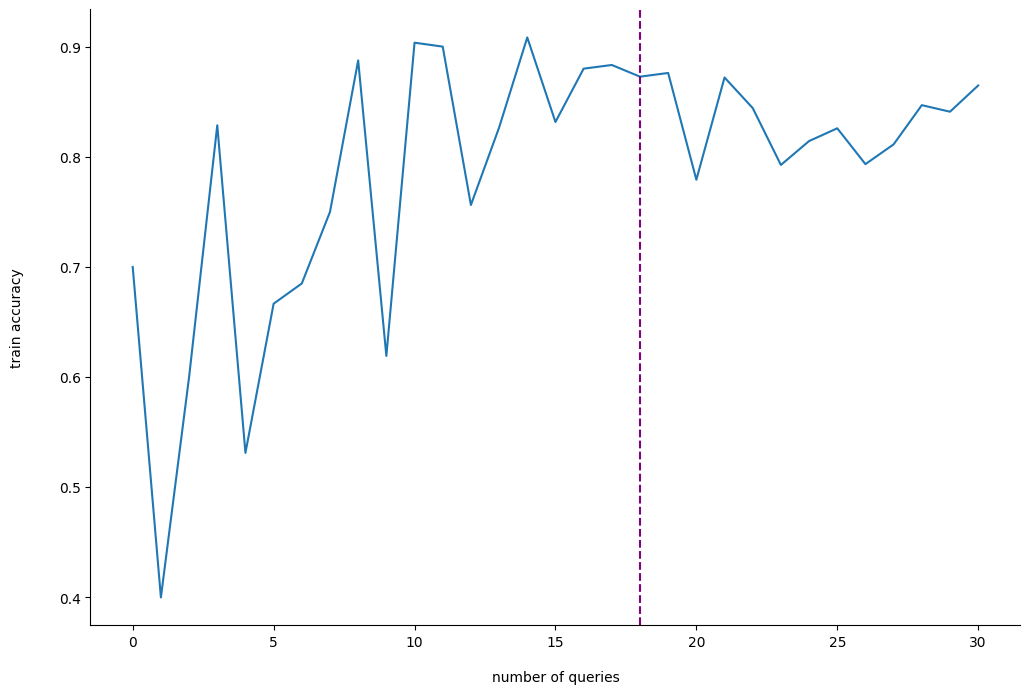

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.array([np.arange(num_queries+1), np.array(results)]).T
df = pd.DataFrame(data, columns=['query', 'accuracy'])
sns.lineplot(x='query', y='accuracy', data=df)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('train accuracy', labelpad=25)

earliest_stopping_response = np.amin([i for i, _ in enumerate(stopping_history) if stopping_history[i] is True])
plt.axvline(x=earliest_stopping_response, ymin=0, ymax=1, color='purple', ls='--')

sns.despine()

In [ ]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(file, test_size=0.2, random_state=0,shuffle=True)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
train = train.rename(columns={"result": "labels", "emails": "text"})
test =  test.rename(columns={"result": "labels", "emails": "text"})
train[["labels","text"]]




,labels,text
0,0,No no:)this is kallis home ground.amla home to...
1,0,I am in escape theatre now. . Going to watch K...
2,0,We walked from my moms. Right on stagwood pass...
3,0,I dunno they close oredi not... ÌÏ v ma fan...
4,0,Yo im right by yo work
...,...,...
4452,0,Match started.india &lt;#&gt; for 2
4453,1,"44 7732584351, Do you want a New Nokia 3510i c..."
4454,0,I was at bugis juz now wat... But now i'm walk...
4455,0,:-) yeah! Lol. Luckily i didn't have a starrin...


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from datasets import Dataset, DatasetDict
dataset_train = Dataset.from_pandas(train[["labels","text"]])
dataset_test =  Dataset.from_pandas(test[["labels","text"]])


In [ ]:
dataset_train[3]

{'labels': 0, 'text': 'I dunno they close oredi not... ÌÏ v ma fan...'}

In [ ]:
dataset_dict = DatasetDict()
dataset_dict["test"] = dataset_test
dataset_dict["train"] = dataset_train

In [ ]:
dataset_dict

DatasetDict({
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 1115
    })
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 4457
    })
})

In [ ]:


from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate
import numpy as np
from transformers import DataCollatorWithPadding

In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.0 MB/s eta 0:00:00


In [ ]:
# Load model directly
model_path = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)


model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=2,
                                                           )


def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding = True)

tokenized_data = dataset_dict.map(preprocess_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

In [ ]:
texts = ["This is a short text.", "This is a much longer text that should be truncated to avoid exceeding the model's maximum length."]

tokenizer(texts, padding = True)

{'input_ids': [[101, 2023, 2003, 1037, 2460, 3793, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2023, 2003, 1037, 2172, 2936, 3793, 2008, 2323, 2022, 25449, 2000, 4468, 17003, 1996, 2944, 1005, 1055, 4555, 3091, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


In [ ]:
# freeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [ ]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
print(model.forward.__code__.co_varnames)

('self', 'input_ids', 'attention_mask', 'token_type_ids', 'position_ids', 'head_mask', 'inputs_embeds', 'labels', 'output_attentions', 'output_hidden_states', 'return_dict', 'outputs', 'pooled_output', 'logits', 'loss', 'loss_fct', 'output')


In [ ]:
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    # get predictions
    predictions, labels = eval_pred

    # apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)
    # use probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]
    # compute auc
    auc = np.round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'],3)

    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
    # compute accuracy
    acc = np.round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'],3)

    return {"Accuracy": acc, "AUC": auc}

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn


In [ ]:
# hyperparameters
lr = 2e-5
batch_size = 8
num_epochs = 10

training_args = TrainingArguments(
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"

)


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0 ,4.0]).to("cuda"))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

<ipython-input-64-25e827ea1824>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
preds = trainer.predict(tokenized_data["test"])

In [ ]:
preds

PredictionOutput(predictions=array([[ 0.09835417,  0.23431544],
       [ 0.00964618,  0.32966894],
       [-0.33491075,  0.14738375],
       ...,
       [-0.25849098,  0.3752259 ],
       [-0.30354434,  0.28172213],
       [-0.4185957 ,  0.02591127]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.7666409015655518, 'test_model_preparation_time': 0.0034, 'test_Accuracy': 0.201, 'test_AUC': 0.554, 'test_runtime': 11.0184, 'test_samples_per_second': 101.195, 'test_steps_per_second': 12.706})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.146600,0.036710,0.994000,0.999000
2,0.042800,0.063444,0.996000,0.999000
3,0.005900,0.057470,0.996000,0.998000


KeyboardInterrupt: 

In [ ]:
print("Пример данных:", tokenized_data["train"][0])
print("Тип меток:", type(tokenized_data["train"][0]["labels"]))

Пример данных: {'labels': 'Not Spam', 'text': 'kallis home ground amla home town durban', 'input_ids': [101, 10556, 21711, 2188, 2598, 2572, 2721, 2188, 2237, 25040, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Тип меток: <class 'str'>
